# Index
1. [RandomForestClassifier](#rfc)
2. [RandomForestClassifier/SMOTE](#rfcs)
3. [RandomForestClassifier/SMOTENC](#rfcsnc)
4. [RandomForestClassifier/RandomOverSampler 'auto'](#rfcrosa)

# Pre-Processing
* Removed outliers
* Size: 9709 > 9316, 4.04% reduction
* Class representation
    * 1 | 0.15197
    * 2 | 0.84803

### Target
* Eligable for a credit card (1)
* Not eligable (0)


### Observations
* The minority class (1) is under represented by a significant margin, so we should consider upsampling to balance it out (SMOTE)
  * It turns out minority class upsampling may be ineffectual, let's test it and find out
* At a glance, features like total_income, account_length, and age seem to be (approximately) normally distributed for the (1) class, despite an initial assumption that such features should probably follow a left skew (ie. higher total income > more credit cards, longer account length > more credit cards, etc)
* Of the earners in this set, a mean of ~180k (std ~100k) and still such a low credit acceptance rate suggests the credit card requirements may be quite high


In [ ]:
#https://www.kaggle.com/datasets/rohit265/credit-card-eligibility-data-determining-factors

from IPython.display import Markdown, Javascript
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns
import warnings
import random
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.set_context(rc = {'patch.linewidth': 1.0})
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE, SMOTENC, RandomOverSampler

random_state = 42
random.seed(random_state)

In [ ]:
df_raw = pd.read_csv("dataset.csv")

In [ ]:
def summary_summary(df):

    def count_outliers(df):
        outliers = {}
        for col in df.select_dtypes(include=[np.number]).columns:
            outliers[col] = (df[col] > df[col].quantile(0.99)).sum()
        return pd.Series(outliers)

    summary = df_raw.describe().T[["count", "mean", "std", "min", "max"]]

    s = pd.DataFrame({
        "unique": pd.Series([len(df_raw[x].value_counts()) for x in df_raw.columns], index=df_raw.columns),
        "null": df_raw.isnull().sum(),
        "dtypes": df_raw.dtypes,
        "dupe": [df_raw.duplicated().sum() for x in df_raw.columns],
        "outliers": count_outliers(df_raw)
    })
    s = pd.concat([s, summary], axis=1).fillna(" ")
    s["outliers"] = [int(x) if x != " " else " " for x in s["outliers"]]
    s["count"] = [int(x) if x != " " else " " for x in s["count"]]
    return s.sort_values("dtypes")

summary_summary(df_raw)

,unique,null,dtypes,dupe,outliers,count,mean,std,min,max
Account_length,61,0,int64,0,0,9709,27.270,16.648,0.000,60.000
Unemployed,2,0,int64,0,0,9709,0.175,0.380,0.000,1.000
Target,2,0,int64,0,0,9709,0.132,0.339,0.000,1.000
Phone,2,0,int64,0,0,9709,0.288,0.453,0.000,1.000
Own_property,2,0,int64,0,0,9709,0.672,0.470,0.000,1.000
Own_car,2,0,int64,0,0,9709,0.368,0.482,0.000,1.000
Num_family,10,0,int64,0,25,9709,2.183,0.933,1.000,20.000
Work_phone,2,0,int64,0,0,9709,0.217,0.413,0.000,1.000
Num_children,9,0,int64,0,26,9709,0.423,0.767,0.000,19.000
ID,9709,0,int64,0,98,9709,5076104.679,40802.696,5008804.000,5150479.000


In this case, the only data cleaning we should do to make our model more accurate is remove outliers

In [ ]:
#Function to remove outliers based on the 99th percentile
def remove_outliers(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        upper_limit = df[col].quantile(0.99)
        df = df[df[col] <= upper_limit]
    return df

# Remove outliers
df_cleaned = remove_outliers(df_raw)
print("Old shape:", df_raw.shape)
print("New shape:", df_cleaned.shape)

Old shape: (9709, 20)
New shape: (9316, 20)


## Process

1. Pre-process data
    1. Train/Test split 0.8/0.2
    2. Standardize features with StandardScalar()
    3. Apply SMOTE upsampling to the data
        * Original value count for each class: [8087, 1229] Total length **9316**
        * Smote value count for each class: [6464, 6464] Total length **12928**
        * I didn't downsample the majority class because I'm lazy
2. Identify feature importance
    * Random Forest Impurity feature importance does fine with either scaled or unscaled SMOTE data, permutation feature importance requires scaled data (https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html)
    * RFI feature importance and permutation feature importance were inconsistent, which set of each provides the highest accuracy?
3. Grab top 1 > 10 features from each feature importance scale (20 total), determine best combo
    * Permutation feature importance with top 9 features is most important at 0.81
4. With 9 features from permuation feature importance, tweak RandomForestClassifier with variable inputs
        param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
        }
5. Train the classifier on the best identified parameters
6. Predict with the test data
7. Evaluate
    * **Accuracy with Tuned Model: 0.81**


# Raw Data Visualizations
---
A quick visual understanding of the raw data and how it relates to the target classes

<IPython.core.display.Javascript object>

##Overview

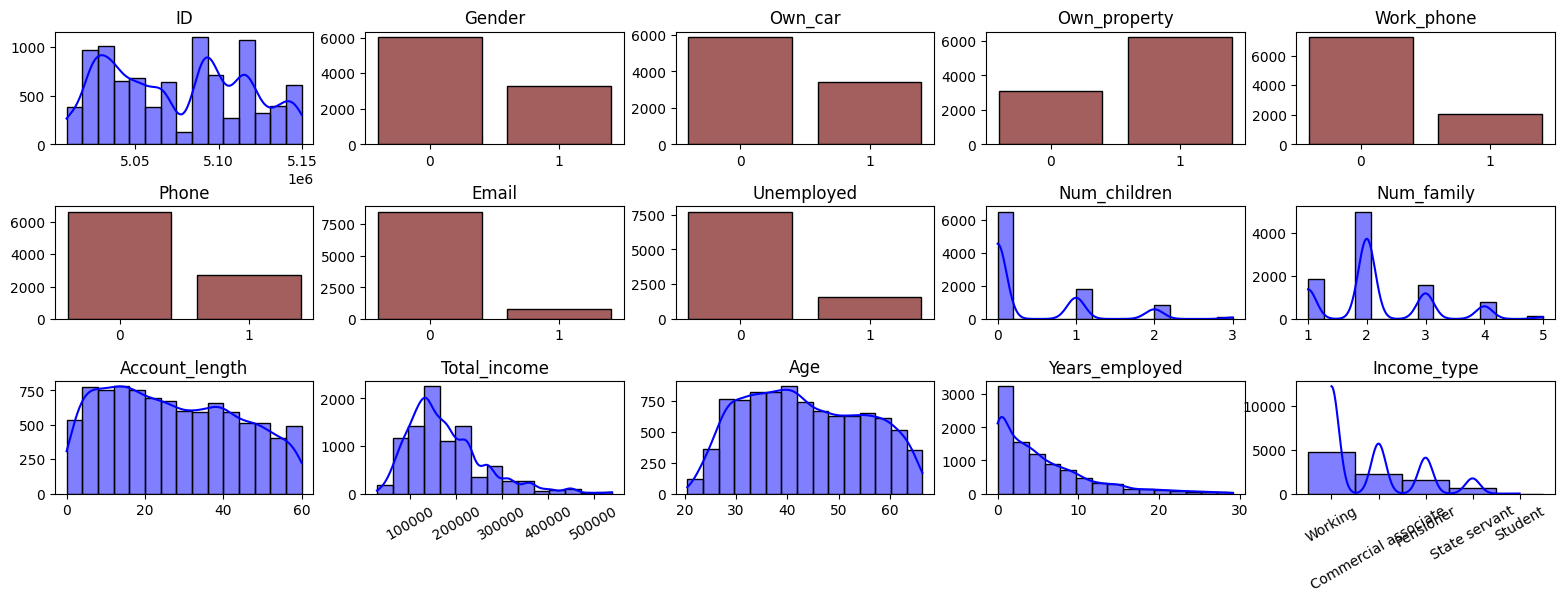

##Data comparisons by Target (Credit Card Owners)

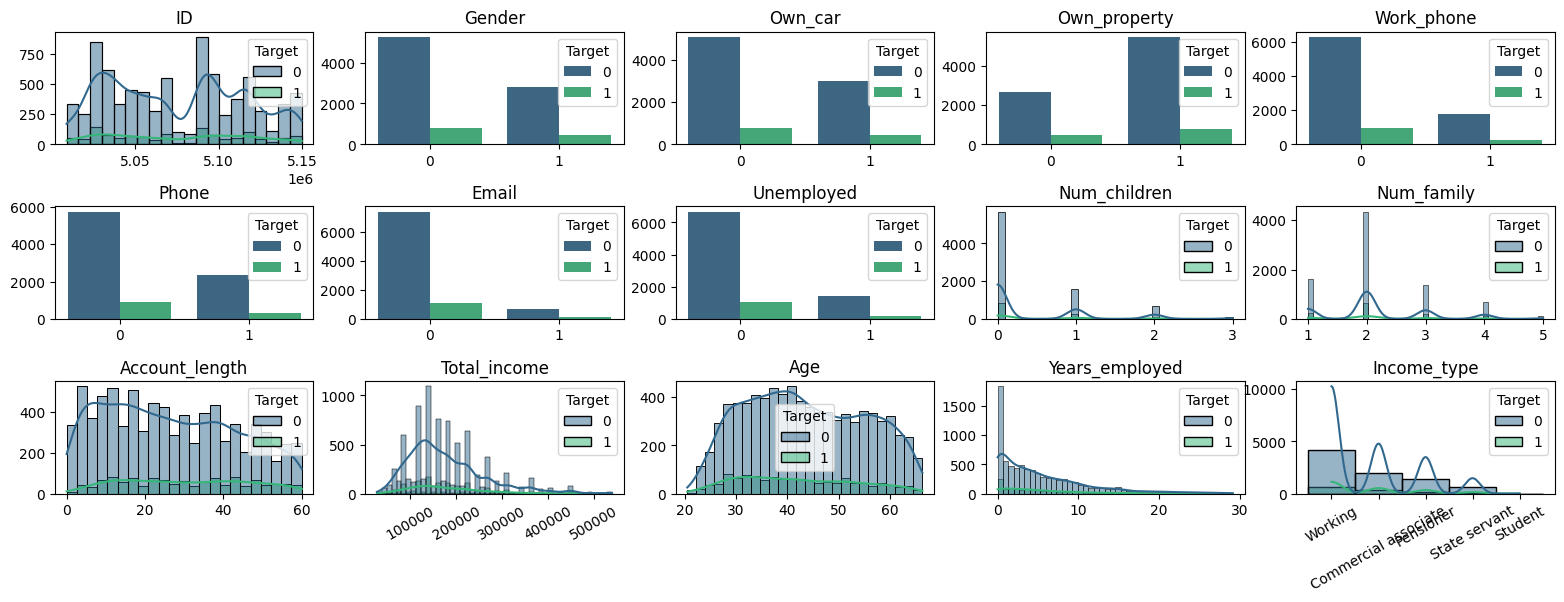

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'''))

def data_viz(df):
    fig = plt.figure(figsize=(8,6))
    gs = gridspec.GridSpec(3, 5, right=2, hspace=0.55)
    display(Markdown("##Overview"))
    axs = []
    for y in range(3):
        for x in range(5):
            ax = fig.add_subplot(gs[y, x])
            axs.append(ax)
            col = df.columns[((y*5) + x) % len(df.columns)]
            if len(df[ col ].value_counts()) == 2:
                g = sns.barplot(x=[0, 1], y=[ len(df[df[col] == 0]), len(df[df[col] == 1])], color="#AF5252", ax=ax,edgecolor="0")
            else:
                g = sns.histplot(df[ col ], kde=True, bins=15, color='blue', ax=ax)
            g.set(ylabel=None, xlabel=None)
            g.set_title(col)
            if col in ["Total_income", "Income_type"]: g.set_xticklabels(g.get_xticklabels(), rotation=30)
    plt.show()


    fig = plt.figure(figsize=(8,6))
    gs = gridspec.GridSpec(3, 5, right=2, hspace=0.55)
    display(Markdown("##Data comparisons by Target (Credit Card Owners)"))
    axs = []
    for y in range(3):
        for x in range(5):
            ax = fig.add_subplot(gs[y, x])
            axs.append(ax)
            col = df.columns[((y*5) + x) % len(df.columns)]
            if len(df[ col ].value_counts()) == 2:
                g = sns.countplot(data=df, x=col, hue='Target', palette='viridis', ax=ax)
            else:
                g = sns.histplot(data=df, x=col, hue='Target', palette='viridis', kde=True, ax=ax)
            g.set(ylabel=None, xlabel=None)
            g.set_title(col)
            if col in ["Total_income", "Income_type"]: g.set_xticklabels(g.get_xticklabels(), rotation=30)
    plt.show()

data_viz(df_cleaned)

# RandomForestClassifier <a name='rfc'></a>
```
Accuracy with Tuned Model: 0.85
Classification Report with Tuned Model:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      1588
           1       0.50      0.00      0.01       276

    accuracy                           0.85      1864
   macro avg       0.68      0.50      0.46      1864
weighted avg       0.80      0.85      0.78      1864

Confusion Matrix with Tuned Model:
[[1587    1]
 [ 275    1]]
```

## Train Test Split / Scale / ROS

In [ ]:
df = df_cleaned.drop(columns=["ID"])
df = df.select_dtypes(include=['int64', 'float64'])
X = df.drop('Target', axis=1)
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

s = StandardScaler()

Xtr_scaled = s.fit_transform(X_train)
Xts_scaled = s.transform(X_test)

# ros = RandomOverSampler(sampling_strategy='auto')

# Xtr_ros_scaled, ytr_ros = ros.fit_resample(Xtr_scaled, y_train)

## Identifying feature importance

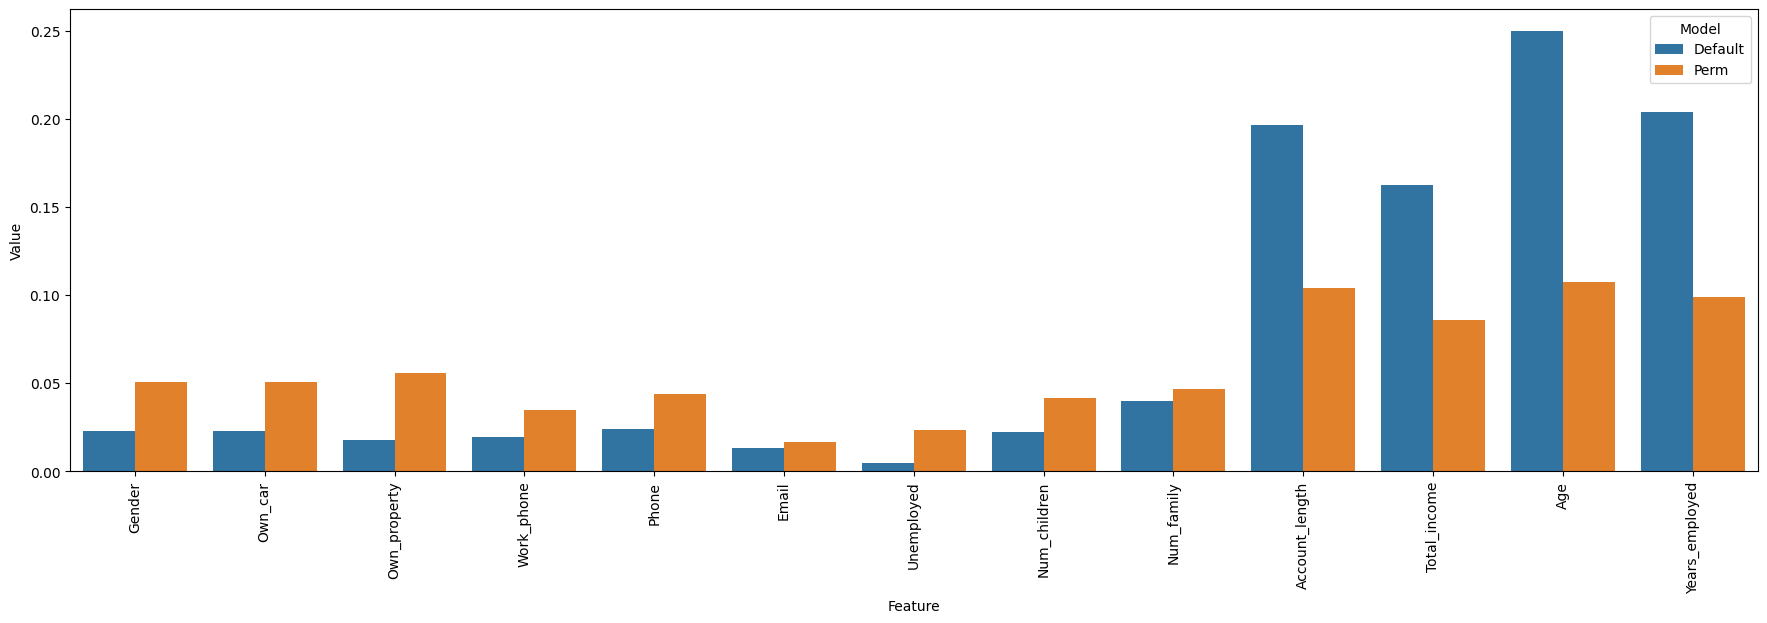

In [ ]:
# RF Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=random_state)
rf_classifier.fit(Xtr_scaled, y_train)

features = X.columns

from sklearn.inspection import permutation_importance

# Permutation feature importance
result = permutation_importance(
    rf_classifier, Xtr_scaled, y_train, n_repeats=10, random_state=random_state, n_jobs=2
)

default_feature_importance = pd.DataFrame({'Feature': features, 'Value': rf_classifier.feature_importances_, "Model": ["Default" for x in range(len(rf_classifier.feature_importances_))]})
permutation_feature_importance = pd.DataFrame({'Feature': features, 'Value': result.importances_mean, "Model": ["Perm" for x in range(len(result.importances_mean))]})
combined = pd.concat([default_feature_importance, permutation_feature_importance], axis=0)

fig = plt.figure(figsize=(9,6))
gs = gridspec.GridSpec(1, 1, right=2)
ax1 = fig.add_subplot(gs[0, 0])

g = sns.barplot(combined, x="Feature", y="Value", hue="Model", ax=ax1)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

## Selecting Features

In [ ]:
# Which feature importance do we like better?

default = {}
perm = {}
# Only gonna test grabbing the top 2 > 10 features
features = range(2, 11)
# Test every feature selection <loops> times
loops = 3

for feature_len in features:
    print("\n", feature_len, ":", end="")

    # Get top X features from default / permutation feature importance
    top_d = default_feature_importance.sort_values("Value").tail(feature_len)["Feature"].tolist()
    top_p = permutation_feature_importance.sort_values("Value").tail(feature_len)["Feature"].tolist()

    # Turn those feature names into col indices
    col_indices_d = [X.columns.get_loc(x) for x in top_d]
    col_indices_p = [X.columns.get_loc(x) for x in top_p]

    # ===========================
    # Default Permutation Feature Importance
    # Select top X features
    Xtr_top_scaled = Xtr_scaled[:,col_indices_d]
    Xts_top_scaled = Xts_scaled[:,col_indices_d]

    for loop in range(loops):
        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=random_state * feature_len + loop)
        rf_classifier.fit(Xtr_top_scaled, y_train)
        print("d", end="")

        # Score the classifier
        if feature_len in default:
            default[feature_len].append(rf_classifier.score(Xts_top_scaled, y_test))
        else:
            default[feature_len] = [rf_classifier.score(Xts_top_scaled, y_test)]

    # ===========================
    # Permutation-based feature importance
    # Select top X features
    Xtr_top_scaled = Xtr_scaled[:,col_indices_p]
    Xts_top_scaled = Xts_scaled[:,col_indices_p]

    for loop in range(loops):
        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=random_state * feature_len + loop)
        rf_classifier.fit(Xtr_top_scaled, y_train)
        print("p", end="")

        # Score the classifier
        if feature_len in perm:
            perm[feature_len].append(rf_classifier.score(Xts_top_scaled, y_test))
        else:
            perm[feature_len] = [rf_classifier.score(Xts_top_scaled, y_test)]


 2 :dddppp
 3 :dddppp
 4 :dddppp
 5 :dddppp
 6 :dddppp
 7 :dddppp
 8 :dddppp
 9 :dddppp
 10 :dddppp

In [ ]:
import pprint

print("Default features")
for k,v in default.items():
    print(k, ":", sum(v) / len(v))
print("Permuted features")
for k,v in perm.items():
    print(k, ":", sum(v) / len(v))

Default features
2 : 0.8356580829756796
3 : 0.8410228898426323
4 : 0.8483547925608012
5 : 0.8512160228898425
6 : 0.8510371959942775
7 : 0.8513948497854078
8 : 0.8522889842632332
9 : 0.851931330472103
10 : 0.851931330472103
Permuted features
2 : 0.7945278969957082
3 : 0.8412017167381974
4 : 0.8472818311874106
5 : 0.8490701001430615
6 : 0.8485336194563663
7 : 0.8510371959942775
8 : 0.8522889842632332
9 : 0.851931330472103
10 : 0.8522889842632332


Default feature importance > top 8 default has the greatest score

## Training the model

In [ ]:
top = default_feature_importance.sort_values("Value").tail(8)["Feature"].tolist()
col_indices = [X_train.columns.get_loc(x) for x in top]

Xtr_top_scaled = Xtr_scaled[:,col_indices]
Xts_top_scaled = Xts_scaled[:,col_indices]

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=random_state),
                           param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2)

grid_search.fit(Xtr_top_scaled, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [ ]:
# Train the Random Forest classifier with best parameters
best_params = grid_search.best_params_
rf_classifier_tuned = RandomForestClassifier(**best_params, random_state=random_state)
rf_classifier_tuned.fit(Xtr_top_scaled, y_train)

# Make predictions using the tuned model
y_pred_tuned = rf_classifier_tuned.predict(Xts_top_scaled)

# Evaluate the tuned model
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f'Accuracy with Tuned Model: {accuracy_tuned:.2f}')
print('Classification Report with Tuned Model:')
print(classification_report(y_test, y_pred_tuned))
print('Confusion Matrix with Tuned Model:')
print(confusion_matrix(y_test, y_pred_tuned))

Accuracy with Tuned Model: 0.85
Classification Report with Tuned Model:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      1588
           1       0.50      0.00      0.01       276

    accuracy                           0.85      1864
   macro avg       0.68      0.50      0.46      1864
weighted avg       0.80      0.85      0.78      1864

Confusion Matrix with Tuned Model:
[[1587    1]
 [ 275    1]]


# RandomForestClassifier / SMOTE <a name='rfcs'></a>
```
Accuracy with Tuned Model: 0.80
Classification Report with Tuned Model:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1588
           1       0.15      0.07      0.10       276

    accuracy                           0.80      1864
   macro avg       0.50      0.50      0.49      1864
weighted avg       0.75      0.80      0.77      1864

Confusion Matrix with Tuned Model:
[[1477  111]
 [ 256   20]]
```

## Train Test Split / Scale / SMOTE

In [ ]:
df = df_cleaned.drop(columns=["ID"])
df = df.select_dtypes(include=['int64', 'float64'])
X = df.drop('Target', axis=1)
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

s = StandardScaler()

Xtr_scaled = s.fit_transform(X_train)
Xts_scaled = s.transform(X_test)

smote = SMOTE(random_state=random_state)

Xtr_smote_scaled, ytr_smote = smote.fit_resample(Xtr_scaled, y_train)

## Comparing the effectiveness of SMOTE sampling

Original data length: 9316 == Smote data length: 12998
Original value count for each class: [8087, 1229]
Smote value count for each class: [6499, 6499]


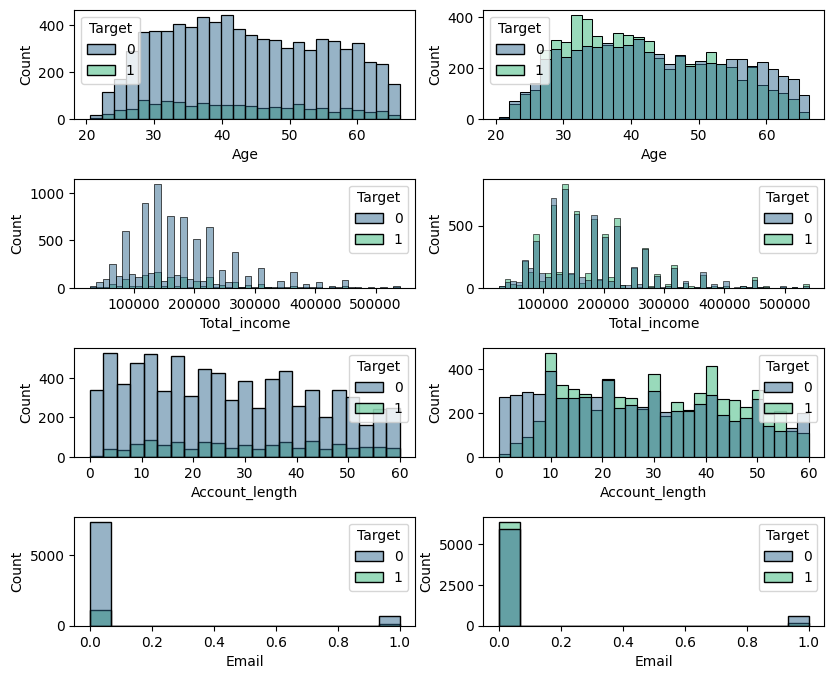

In [ ]:
a, b = smote.fit_resample(X_train, y_train)
df_smote = pd.concat([a, b], axis=1)
print("Original data length:", len( df_cleaned ), "== Smote data length:", len( df_smote ))
print("Original value count for each class:", df_cleaned["Target"].value_counts().tolist())
print("Smote value count for each class:", df_smote["Target"].value_counts().tolist())
fig = plt.figure(figsize=(4,8))
gs = gridspec.GridSpec(4, 2, right=2, hspace=0.55)
for idx,i in enumerate(["Age", "Total_income", "Account_length", "Email"]):
    ax1 = fig.add_subplot(gs[idx, 0])
    ax2 = fig.add_subplot(gs[idx, 1])
    sns.histplot(data=df_smote, x=i, hue='Target', palette='viridis', ax=ax2)
    sns.histplot(data=df_cleaned, x=i, hue='Target', palette='viridis', ax=ax1)

## Identifying feature importance

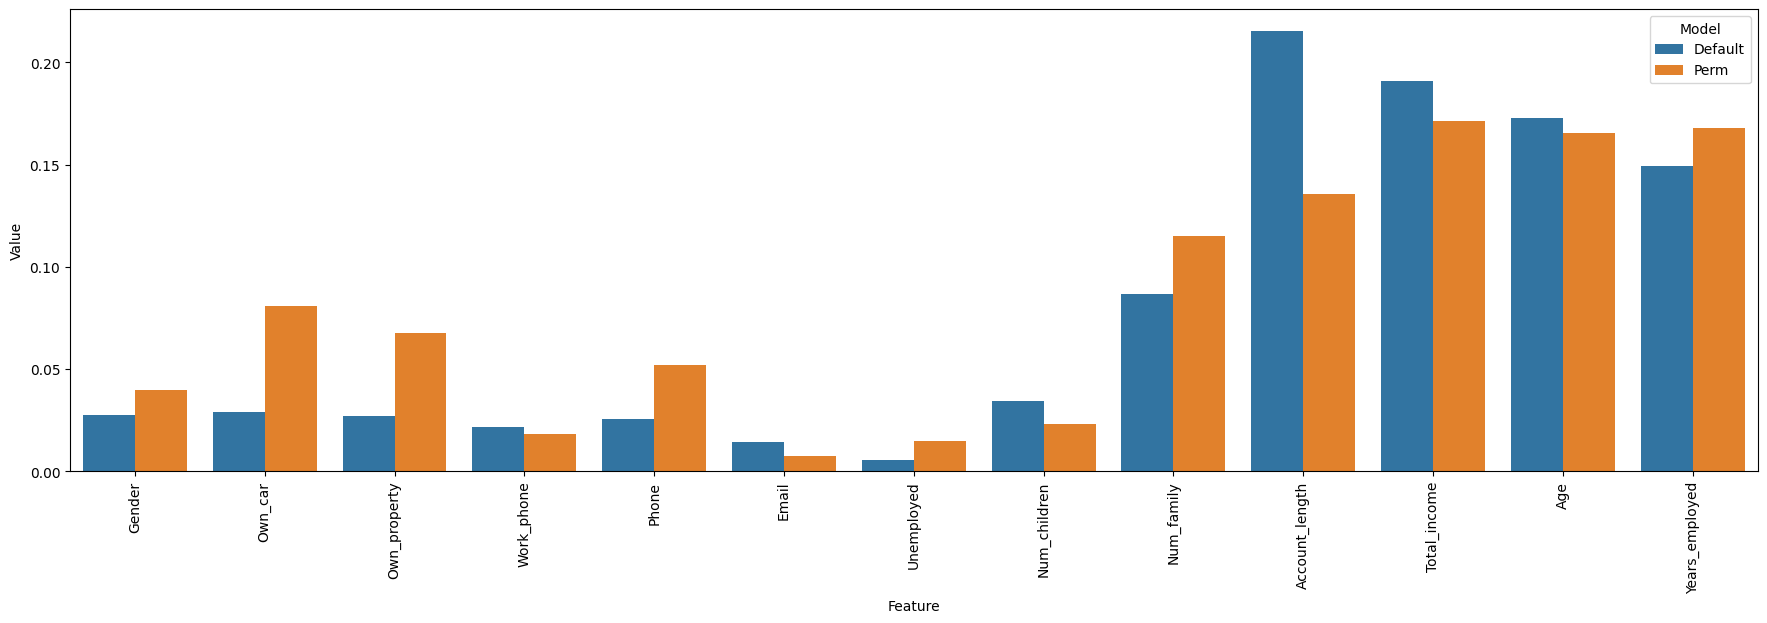

In [ ]:
# RF Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=random_state)
rf_classifier.fit(Xtr_smote_scaled, ytr_smote)

features = X.columns

from sklearn.inspection import permutation_importance

# Permutation feature importance
result = permutation_importance(
    rf_classifier, Xtr_smote_scaled, ytr_smote, n_repeats=10, random_state=random_state, n_jobs=2
)

default_feature_importance = pd.DataFrame({'Feature': features, 'Value': rf_classifier.feature_importances_, "Model": ["Default" for x in range(len(rf_classifier.feature_importances_))]})
permutation_feature_importance = pd.DataFrame({'Feature': features, 'Value': result.importances_mean, "Model": ["Perm" for x in range(len(result.importances_mean))]})
combined = pd.concat([default_feature_importance, permutation_feature_importance], axis=0)

fig = plt.figure(figsize=(9,6))
gs = gridspec.GridSpec(1, 1, right=2)
ax1 = fig.add_subplot(gs[0, 0])

g = sns.barplot(combined, x="Feature", y="Value", hue="Model", ax=ax1)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

## Selecting Features

In [ ]:
# Which feature importance do we like better?

default = {}
perm = {}
# Only gonna test grabbing the top 2 > 10 features
features = range(2, 11)
# Test every feature selection <loops> times
loops = 3

for feature_len in features:
    print("\n", feature_len, ":", end="")

    # Get top X features from default / permutation feature importance
    top_d = default_feature_importance.sort_values("Value").tail(feature_len)["Feature"].tolist()
    top_p = permutation_feature_importance.sort_values("Value").tail(feature_len)["Feature"].tolist()

    # Turn those feature names into col indices
    col_indices_d = [X.columns.get_loc(x) for x in top_d]
    col_indices_p = [X.columns.get_loc(x) for x in top_p]

    # ===========================
    # Default Permutation Feature Importance
    # Select top X features
    Xtr_top_smote_scaled = Xtr_smote_scaled[:,col_indices_d]
    Xts_top_scaled = Xts_scaled[:,col_indices_d]

    for loop in range(loops):
        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=random_state * feature_len + loop)
        rf_classifier.fit(Xtr_top_smote_scaled, ytr_smote)
        print("d", end="")

        # Score the classifier
        if feature_len in default:
            default[feature_len].append(rf_classifier.score(Xts_top_scaled, y_test))
        else:
            default[feature_len] = [rf_classifier.score(Xts_top_scaled, y_test)]

    # ===========================
    # Permutation-based feature importance
    # Select top X features
    Xtr_top_smote_scaled = Xtr_smote_scaled[:,col_indices_p]
    Xts_top_scaled = Xts_scaled[:,col_indices_p]

    for loop in range(loops):
        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=random_state * feature_len + loop)
        rf_classifier.fit(Xtr_top_smote_scaled, ytr_smote)
        print("p", end="")

        # Score the classifier
        if feature_len in perm:
            perm[feature_len].append(rf_classifier.score(Xts_top_scaled, y_test))
        else:
            perm[feature_len] = [rf_classifier.score(Xts_top_scaled, y_test)]


 2 :dddppp
 3 :dddppp
 4 :dddppp
 5 :dddppp
 6 :dddppp
 7 :dddppp
 8 :dddppp
 9 :dddppp
 10 :dddppp

In [ ]:
import pprint

print("Default features")
for k,v in default.items():
    print(k, ":", sum(v) / len(v))
print("Permuted features")
for k,v in perm.items():
    print(k, ":", sum(v) / len(v))

Default features
2 : 0.8061516452074392
3 : 0.7308655221745349
4 : 0.7371244635193133
5 : 0.7609084406294707
6 : 0.7621602288984263
7 : 0.7673462088698141
8 : 0.7743204577968527
9 : 0.7811158798283261
10 : 0.7913090128755366
Permuted features
2 : 0.6931330472103004
3 : 0.6951001430615165
4 : 0.7381974248927038
5 : 0.7578683834048641
6 : 0.7639484978540771
7 : 0.7718168812589413
8 : 0.7719957081545065
9 : 0.7829041487839771
10 : 0.7905937052932761


Default feature importance > top 2 default has the greatest score

## Training the model

In [ ]:
top = default_feature_importance.sort_values("Value").tail(2)["Feature"].tolist()
col_indices = [X_train.columns.get_loc(x) for x in top]

Xtr_top_smote_scaled = Xtr_smote_scaled[:,col_indices]
Xts_top_scaled = Xts_scaled[:,col_indices]

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rfsmote = GridSearchCV(estimator=RandomForestClassifier(random_state=random_state),
                           param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2)

grid_search_rfsmote.fit(Xtr_top_smote_scaled, ytr_smote)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [ ]:
# Train the Random Forest classifier with best parameters
best_params_rfsmote = grid_search_rfsmote.best_params_
rf_classifier_tuned_rfsmote = RandomForestClassifier(**best_params_rfsmote, random_state=random_state)
rf_classifier_tuned_rfsmote.fit(Xtr_top_smote_scaled, ytr_smote)

# Make predictions using the tuned model
y_pred_tuned = rf_classifier_tuned_rfsmote.predict(Xts_top_scaled)

# Evaluate the tuned model
accuracy_tuned_rfsmote = accuracy_score(y_test, y_pred_tuned)
print(f'Accuracy with Tuned Model: {accuracy_tuned_rfsmote:.2f}')
print('Classification Report with Tuned Model:')
print(classification_report(y_test, y_pred_tuned))
print('Confusion Matrix with Tuned Model:')
print(confusion_matrix(y_test, y_pred_tuned))

Accuracy with Tuned Model: 0.80
Classification Report with Tuned Model:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1588
           1       0.15      0.07      0.10       276

    accuracy                           0.80      1864
   macro avg       0.50      0.50      0.49      1864
weighted avg       0.75      0.80      0.77      1864

Confusion Matrix with Tuned Model:
[[1477  111]
 [ 256   20]]


# RandomForestClassifier / SMOTENC <a name='rfcsnc'></a>
```
Accuracy with Tuned Model: 0.80
Classification Report with Tuned Model:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1588
           1       0.14      0.06      0.08       276

    accuracy                           0.80      1864
   macro avg       0.49      0.50      0.49      1864
weighted avg       0.75      0.80      0.77      1864

Confusion Matrix with Tuned Model:
[[1480  108]
 [ 259   17]]
```

## Process

I Realized i only need to do scaling and SMOTE once on the dataset, and then select features independently. I dont need to do SMOTE and Scaling every iteration of feature selection

## One-hot encode categorical columns for SMOTENC

SMOTENC requires differentiation between Nominal & Categorical columns, so here we add all of the nominal cols to the end of the dataframe and one-hot encode the categorical columns

In [ ]:
df = df_cleaned.drop(columns=["ID"])
one_hot1 = pd.get_dummies(df_cleaned["Income_type"], dtype=int)
one_hot2 = pd.get_dummies(df_cleaned["Education_type"], dtype=int)
one_hot3 = pd.get_dummies(df_cleaned["Family_status"], dtype=int)
one_hot4 = pd.get_dummies(df_cleaned["Housing_type"], dtype=int)
one_hot5 = pd.get_dummies(df_cleaned["Occupation_type"], dtype=int)
df = df.drop(columns=["Income_type", "Education_type", "Family_status", "Housing_type", "Occupation_type"],axis = 1)
for i in [one_hot1, one_hot2, one_hot3, one_hot4, one_hot5]:
    df = df.join(i)
df["Num_children"] = df.pop("Num_children")
df["Num_family"] = df.pop("Num_family")
df["Account_length"] = df.pop("Account_length")
df["Total_income"] = df.pop("Total_income")
df["Age"] = df.pop("Age")
df["Years_employed"] = df.pop("Years_employed")

## Train Test Split / Scale / SMOTE

In [ ]:
X = df.drop('Target', axis=1)
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

s = StandardScaler()

Xtr_scaled = s.fit_transform(X_train)
Xts_scaled = s.transform(X_test)

smote = SMOTENC(random_state=random_state, categorical_features=list(range(0, 49)))

Xtr_smote_scaled, ytr_smote = smote.fit_resample(Xtr_scaled, y_train)

## Comparing the effectiveness of SMOTE sampling

Original data length: 9316 == Smote data length: 12998
Original value count for each class: [8087, 1229]
Smote value count for each class: [6499, 6499]


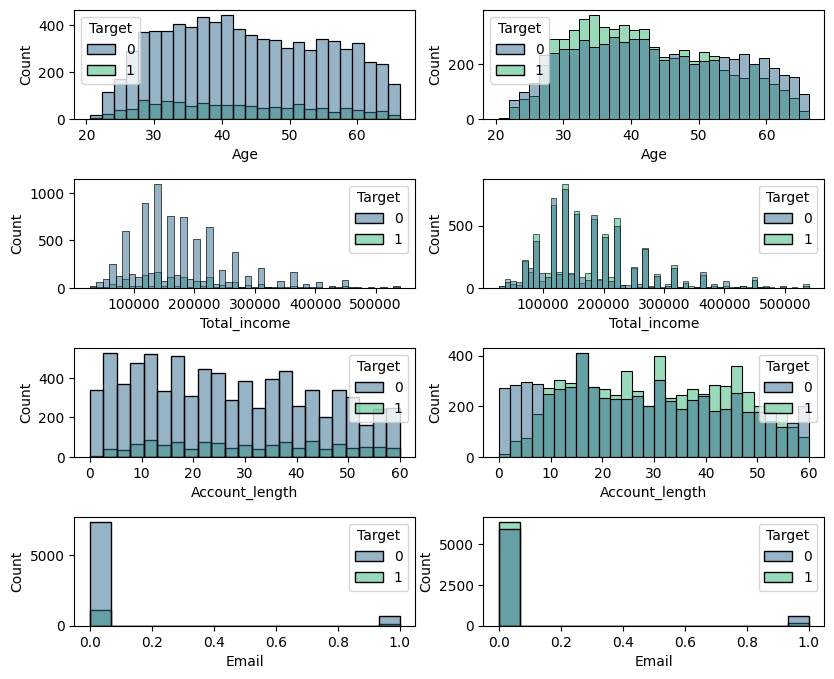

In [ ]:
a, b = smote.fit_resample(X_train, y_train)
df_smote = pd.concat([a, b], axis=1)
print("Original data length:", len( df_cleaned ), "== Smote data length:", len( df_smote ))
print("Original value count for each class:", df_cleaned["Target"].value_counts().tolist())
print("Smote value count for each class:", df_smote["Target"].value_counts().tolist())
fig = plt.figure(figsize=(4,8))
gs = gridspec.GridSpec(4, 2, right=2, hspace=0.55)
for idx,i in enumerate(["Age", "Total_income", "Account_length", "Email"]):
    ax1 = fig.add_subplot(gs[idx, 0])
    ax2 = fig.add_subplot(gs[idx, 1])
    sns.histplot(data=df_smote, x=i, hue='Target', palette='viridis', ax=ax2)
    sns.histplot(data=df_cleaned, x=i, hue='Target', palette='viridis', ax=ax1)

## Identifying feature importance

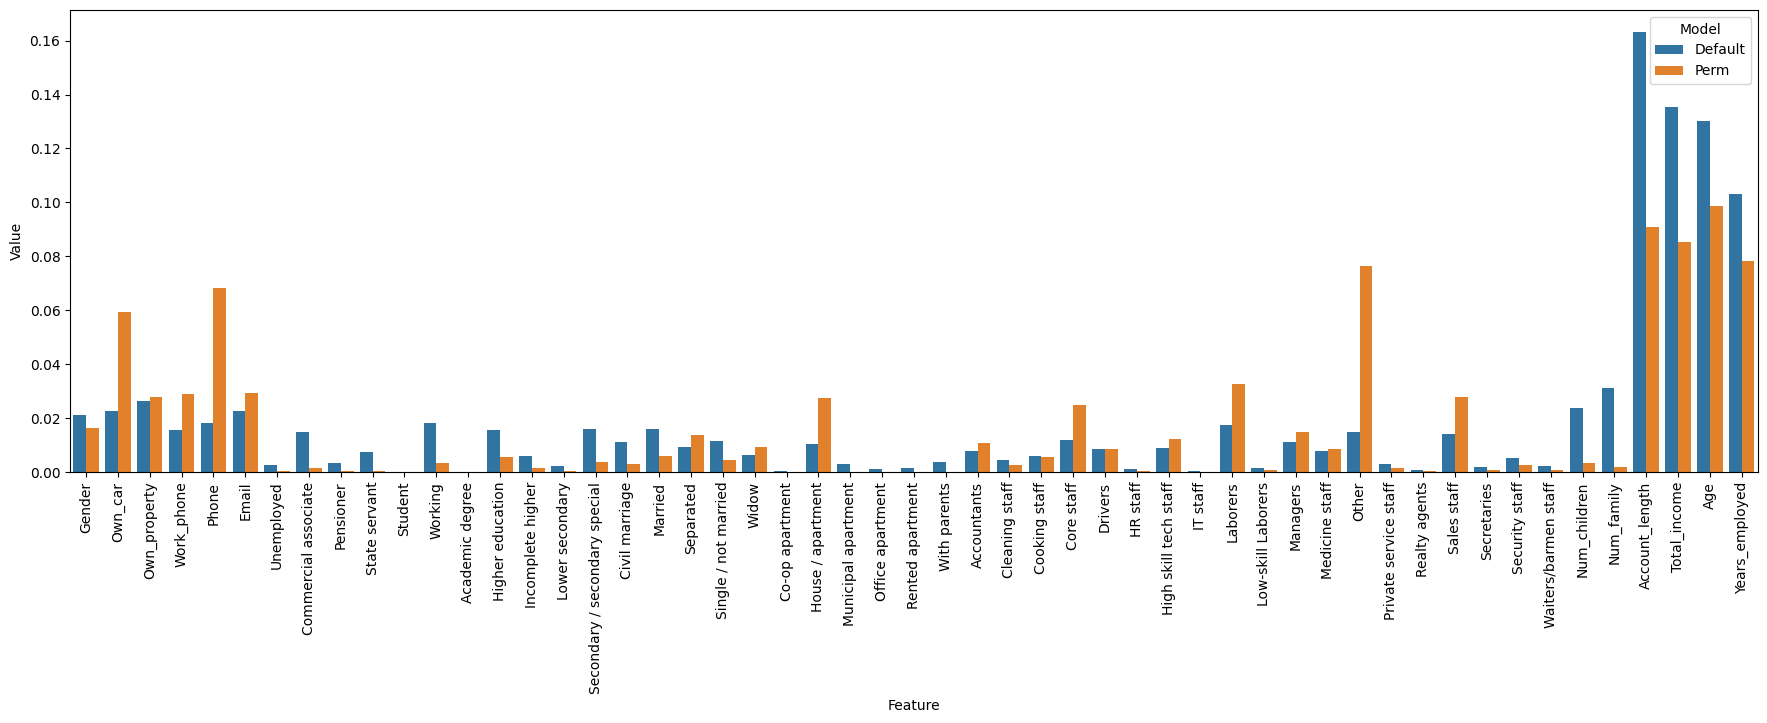

In [ ]:
# RF Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=random_state)
rf_classifier.fit(Xtr_smote_scaled, ytr_smote)

features = X.columns

from sklearn.inspection import permutation_importance

# Permutation feature importance
result = permutation_importance(
    rf_classifier, Xtr_smote_scaled, ytr_smote, n_repeats=10, random_state=random_state, n_jobs=2
)

default_feature_importance = pd.DataFrame({'Feature': features, 'Value': rf_classifier.feature_importances_, "Model": ["Default" for x in range(len(rf_classifier.feature_importances_))]})
permutation_feature_importance = pd.DataFrame({'Feature': features, 'Value': result.importances_mean, "Model": ["Perm" for x in range(len(result.importances_mean))]})
combined = pd.concat([default_feature_importance, permutation_feature_importance], axis=0)

fig = plt.figure(figsize=(9,6))
gs = gridspec.GridSpec(1, 1, right=2)
ax1 = fig.add_subplot(gs[0, 0])

g = sns.barplot(combined, x="Feature", y="Value", hue="Model", ax=ax1)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

## Selecting Features

In [ ]:
# Which feature importance do we like better?

default = {}
perm = {}
# Only gonna test grabbing the top 2 > 10 features
features = range(2, 11)
# Test every feature selection <loops> times
loops = 3

for feature_len in features:
    print("\n", feature_len, ":", end="")

    # Get top X features from default / permutation feature importance
    top_d = default_feature_importance.sort_values("Value").tail(feature_len)["Feature"].tolist()
    top_p = permutation_feature_importance.sort_values("Value").tail(feature_len)["Feature"].tolist()

    # Turn those feature names into col indices
    col_indices_d = [X_train.columns.get_loc(x) for x in top_d]
    col_indices_p = [X_train.columns.get_loc(x) for x in top_p]

    # ===========================
    # Default Permutation Feature Importance
    # Select top X features
    Xtr_top_smote_scaled = Xtr_smote_scaled[:,col_indices_d]
    Xts_top_scaled = Xts_scaled[:,col_indices_d]

    for loop in range(loops):
        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=random_state * feature_len + loop)
        rf_classifier.fit(Xtr_top_smote_scaled, ytr_smote)
        print("d", end="")

        # Score the classifier
        if feature_len in default:
            default[feature_len].append(rf_classifier.score(Xts_top_scaled, y_test))
        else:
            default[feature_len] = [rf_classifier.score(Xts_top_scaled, y_test)]

    # ===========================
    # Permutation-based feature importance
    # Select top X features
    Xtr_top_smote_scaled = Xtr_smote_scaled[:,col_indices_p]
    Xts_top_scaled = Xts_scaled[:,col_indices_p]

    for loop in range(loops):
        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=random_state * feature_len + loop)
        rf_classifier.fit(Xtr_top_smote_scaled, ytr_smote)
        print("p", end="")

        # Score the classifier
        if feature_len in perm:
            perm[feature_len].append(rf_classifier.score(Xts_top_scaled, y_test))
        else:
            perm[feature_len] = [rf_classifier.score(Xts_top_scaled, y_test)]


 2 :dddppp
 3 :dddppp
 4 :dddppp
 5 :dddppp
 6 :dddppp
 7 :dddppp
 8 :dddppp
 9 :dddppp
 10 :dddppp

In [ ]:
import pprint

print("Default features")
for k,v in default.items():
    print(k, ":", sum(v) / len(v))
print("Permuted features")
for k,v in perm.items():
    print(k, ":", sum(v) / len(v))

Default features
2 : 0.8015021459227468
3 : 0.7328326180257511
4 : 0.7408798283261803
5 : 0.7392703862660944
6 : 0.738197424892704
7 : 0.7408798283261803
8 : 0.7387339055793992
9 : 0.7424892703862661
10 : 0.7451716738197426
Permuted features
2 : 0.6550429184549357
3 : 0.7312231759656652
4 : 0.7451716738197426
5 : 0.7446351931330472
6 : 0.7333690987124464
7 : 0.73068669527897
8 : 0.7317596566523606
9 : 0.7521459227467812
10 : 0.7349785407725321


Default feature importance > top 2 default has the greatest score

## Training the model

In [ ]:
top = default_feature_importance.sort_values("Value").tail(2)["Feature"].tolist()
col_indices = [X_train.columns.get_loc(x) for x in top]

Xtr_top_smote_scaled = Xtr_smote_scaled[:,col_indices]
Xts_top_scaled = Xts_scaled[:,col_indices]

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rfsmotenc = GridSearchCV(estimator=RandomForestClassifier(random_state=random_state),
                           param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2)

grid_search_rfsmotenc.fit(Xtr_top_smote_scaled, ytr_smote)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [ ]:
# Train the Random Forest classifier with best parameters
best_params_rfsmotenc = grid_search_rfsmotenc.best_params_
rf_classifier_tuned_rfsmotenc = RandomForestClassifier(**best_params_rfsmotenc, random_state=random_state)
rf_classifier_tuned_rfsmotenc.fit(Xtr_top_smote_scaled, ytr_smote)

# Make predictions using the tuned model
y_pred_tuned = rf_classifier_tuned_rfsmotenc.predict(Xts_top_scaled)

# Evaluate the tuned model
accuracy_tuned_rfsmotenc = accuracy_score(y_test, y_pred_tuned)
print(f'Accuracy with Tuned Model: {accuracy_tuned_rfsmotenc:.2f}')
print('Classification Report with Tuned Model:')
print(classification_report(y_test, y_pred_tuned))
print('Confusion Matrix with Tuned Model:')
print(confusion_matrix(y_test, y_pred_tuned))

Accuracy with Tuned Model: 0.80
Classification Report with Tuned Model:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1588
           1       0.14      0.06      0.08       276

    accuracy                           0.80      1864
   macro avg       0.49      0.50      0.49      1864
weighted avg       0.75      0.80      0.77      1864

Confusion Matrix with Tuned Model:
[[1480  108]
 [ 259   17]]


# RandomForestClassifier / RandomOverSampler ('auto') <a name='rfcrosa'></a>
```
Accuracy with Tuned Model: 0.84
Classification Report with Tuned Model:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      1588
           1       0.26      0.03      0.06       276

    accuracy                           0.84      1864
   macro avg       0.56      0.51      0.49      1864
weighted avg       0.77      0.84      0.79      1864

Confusion Matrix with Tuned Model:
[[1563   25]
 [ 267    9]]
```

## Train Test Split / Scale / ROS

In [ ]:
df = df_cleaned.drop(columns=["ID"])
df = df.select_dtypes(include=['int64', 'float64'])
X = df.drop('Target', axis=1)
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

s = StandardScaler()

Xtr_scaled = s.fit_transform(X_train)
Xts_scaled = s.transform(X_test)

ros = RandomOverSampler(sampling_strategy='auto')

Xtr_ros_scaled, ytr_ros = ros.fit_resample(Xtr_scaled, y_train)

## Comparing the effectiveness of ROS sampling

Original data length: 9316 == ros data length: 12998
Original value count for each class: [8087, 1229]
ros value count for each class: [6499, 6499]


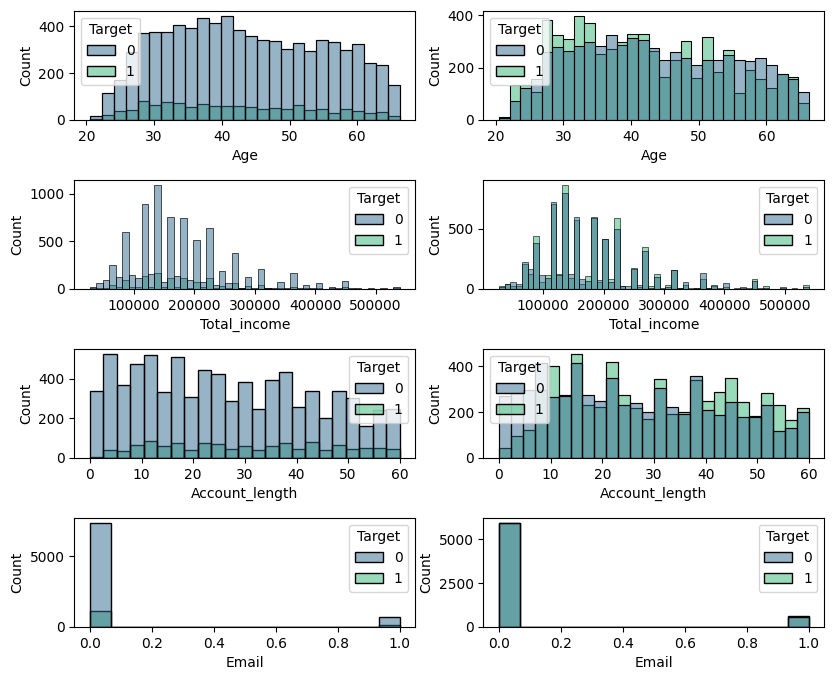

In [ ]:
a, b = ros.fit_resample(X_train, y_train)
df_ros = pd.concat([a, b], axis=1)
print("Original data length:", len( df_cleaned ), "== ros data length:", len( df_ros ))
print("Original value count for each class:", df_cleaned["Target"].value_counts().tolist())
print("ros value count for each class:", df_ros["Target"].value_counts().tolist())
fig = plt.figure(figsize=(4,8))
gs = gridspec.GridSpec(4, 2, right=2, hspace=0.55)
for idx,i in enumerate(["Age", "Total_income", "Account_length", "Email"]):
    ax1 = fig.add_subplot(gs[idx, 0])
    ax2 = fig.add_subplot(gs[idx, 1])
    sns.histplot(data=df_ros, x=i, hue='Target', palette='viridis', ax=ax2)
    sns.histplot(data=df_cleaned, x=i, hue='Target', palette='viridis', ax=ax1)

## Identifying feature importance

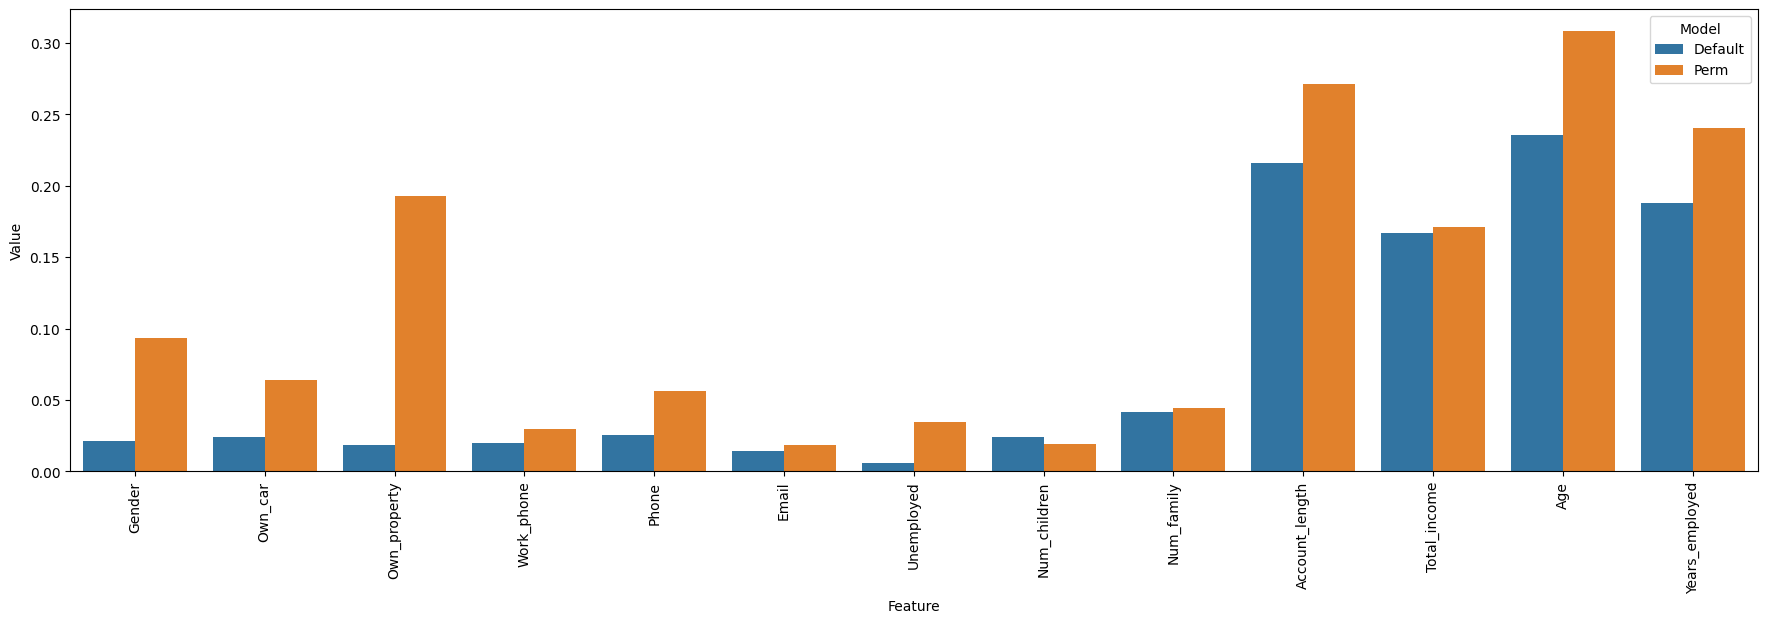

In [ ]:
# RF Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=random_state)
rf_classifier.fit(Xtr_ros_scaled, ytr_ros)

features = X.columns

from sklearn.inspection import permutation_importance

# Permutation feature importance
result = permutation_importance(
    rf_classifier, Xtr_ros_scaled, ytr_ros, n_repeats=10, random_state=random_state, n_jobs=2
)

default_feature_importance = pd.DataFrame({'Feature': features, 'Value': rf_classifier.feature_importances_, "Model": ["Default" for x in range(len(rf_classifier.feature_importances_))]})
permutation_feature_importance = pd.DataFrame({'Feature': features, 'Value': result.importances_mean, "Model": ["Perm" for x in range(len(result.importances_mean))]})
combined = pd.concat([default_feature_importance, permutation_feature_importance], axis=0)

fig = plt.figure(figsize=(9,6))
gs = gridspec.GridSpec(1, 1, right=2)
ax1 = fig.add_subplot(gs[0, 0])

g = sns.barplot(combined, x="Feature", y="Value", hue="Model", ax=ax1)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

## Selecting Features

In [ ]:
# Which feature importance do we like better?

default = {}
perm = {}
# Only gonna test grabbing the top 2 > 10 features
features = range(2, 11)
# Test every feature selection <loops> times
loops = 3

for feature_len in features:
    print("\n", feature_len, ":", end="")

    # Get top X features from default / permutation feature importance
    top_d = default_feature_importance.sort_values("Value").tail(feature_len)["Feature"].tolist()
    top_p = permutation_feature_importance.sort_values("Value").tail(feature_len)["Feature"].tolist()

    # Turn those feature names into col indices
    col_indices_d = [X.columns.get_loc(x) for x in top_d]
    col_indices_p = [X.columns.get_loc(x) for x in top_p]

    # ===========================
    # Default Permutation Feature Importance
    # Select top X features
    Xtr_top_ros_scaled = Xtr_ros_scaled[:,col_indices_d]
    Xts_top_scaled = Xts_scaled[:,col_indices_d]

    for loop in range(loops):
        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=random_state * feature_len + loop)
        rf_classifier.fit(Xtr_top_ros_scaled, ytr_ros)
        print("d", end="")

        # Score the classifier
        if feature_len in default:
            default[feature_len].append(rf_classifier.score(Xts_top_scaled, y_test))
        else:
            default[feature_len] = [rf_classifier.score(Xts_top_scaled, y_test)]

    # ===========================
    # Permutation-based feature importance
    # Select top X features
    Xtr_top_ros_scaled = Xtr_ros_scaled[:,col_indices_p]
    Xts_top_scaled = Xts_scaled[:,col_indices_p]

    for loop in range(loops):
        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=random_state * feature_len + loop)
        rf_classifier.fit(Xtr_top_ros_scaled, ytr_ros)
        print("p", end="")

        # Score the classifier
        if feature_len in perm:
            perm[feature_len].append(rf_classifier.score(Xts_top_scaled, y_test))
        else:
            perm[feature_len] = [rf_classifier.score(Xts_top_scaled, y_test)]


 2 :dddppp
 3 :dddppp
 4 :dddppp
 5 :dddppp
 6 :dddppp
 7 :dddppp
 8 :dddppp
 9 :dddppp
 10 :dddppp

In [ ]:
import pprint

print("Default features")
for k,v in default.items():
    print(k, ":", sum(v) / len(v))
print("Permuted features")
for k,v in perm.items():
    print(k, ":", sum(v) / len(v))

Default features
2 : 0.7592989985693848
3 : 0.8156294706723891
4 : 0.8267167381974249
5 : 0.8324391988555079
6 : 0.8408440629470673
7 : 0.8426323319027181
8 : 0.8420958512160229
9 : 0.844241773962804
10 : 0.8435264663805436
Permuted features
2 : 0.7592989985693848
3 : 0.8156294706723891
4 : 0.8174177396280401
5 : 0.8311874105865522
6 : 0.8335121602288984
7 : 0.8349427753934191
8 : 0.8417381974248928
9 : 0.8410228898426323
10 : 0.8438841201716739


Default feature importance > top 9 default has the greatest score

## Training the model

In [ ]:
top = default_feature_importance.sort_values("Value").tail(9)["Feature"].tolist()
col_indices = [X_train.columns.get_loc(x) for x in top]

Xtr_top_ros_scaled = Xtr_ros_scaled[:,col_indices]
Xts_top_scaled = Xts_scaled[:,col_indices]

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_rfros = GridSearchCV(estimator=RandomForestClassifier(random_state=random_state),
                           param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2)

grid_search_rfros.fit(Xtr_top_ros_scaled, ytr_ros)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [ ]:
# Train the Random Forest classifier with best parameters
best_params_rfros = grid_search_rfros.best_params_
rf_classifier_tuned_rfros = RandomForestClassifier(**best_params_rfros, random_state=random_state)
rf_classifier_tuned_rfros.fit(Xtr_top_ros_scaled, ytr_ros)

# Make predictions using the tuned model
y_pred_tuned = rf_classifier_tuned_rfros.predict(Xts_top_scaled)

# Evaluate the tuned model
accuracy_tuned_rfros = accuracy_score(y_test, y_pred_tuned)
print(f'Accuracy with Tuned Model: {accuracy_tuned_rfros:.2f}')
print('Classification Report with Tuned Model:')
print(classification_report(y_test, y_pred_tuned))
print('Confusion Matrix with Tuned Model:')
print(confusion_matrix(y_test, y_pred_tuned))

Accuracy with Tuned Model: 0.84
Classification Report with Tuned Model:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      1588
           1       0.26      0.03      0.06       276

    accuracy                           0.84      1864
   macro avg       0.56      0.51      0.49      1864
weighted avg       0.77      0.84      0.79      1864

Confusion Matrix with Tuned Model:
[[1563   25]
 [ 267    9]]


# GradientBoostingClassifier / SMOTE <a name='gbs'></a>
```

```

## Train Test Split / Scale / SMOTE

In [ ]:
df = df_cleaned.drop(columns=["ID"])
df = df.select_dtypes(include=['int64', 'float64'])
X = df.drop('Target', axis=1)
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

s = StandardScaler()

Xtr_scaled = s.fit_transform(X_train)
Xts_scaled = s.transform(X_test)

smote = SMOTE(random_state=random_state)

Xtr_smote_scaled, ytr_smote = smote.fit_resample(Xtr_scaled, y_train)

## Comparing the effectiveness of SMOTE sampling

Original data length: 9316 == Smote data length: 12998
Original value count for each class: [8087, 1229]
Smote value count for each class: [6499, 6499]


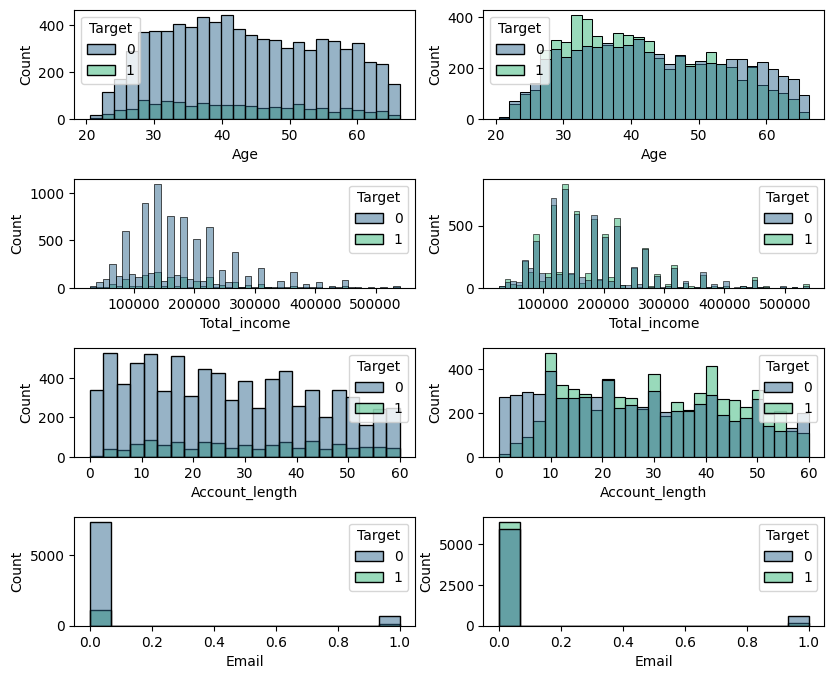

In [ ]:
a, b = smote.fit_resample(X_train, y_train)
df_smote = pd.concat([a, b], axis=1)
print("Original data length:", len( df_cleaned ), "== Smote data length:", len( df_smote ))
print("Original value count for each class:", df_cleaned["Target"].value_counts().tolist())
print("Smote value count for each class:", df_smote["Target"].value_counts().tolist())
fig = plt.figure(figsize=(4,8))
gs = gridspec.GridSpec(4, 2, right=2, hspace=0.55)
for idx,i in enumerate(["Age", "Total_income", "Account_length", "Email"]):
    ax1 = fig.add_subplot(gs[idx, 0])
    ax2 = fig.add_subplot(gs[idx, 1])
    sns.histplot(data=df_smote, x=i, hue='Target', palette='viridis', ax=ax2)
    sns.histplot(data=df_cleaned, x=i, hue='Target', palette='viridis', ax=ax1)

## Identifying feature importance

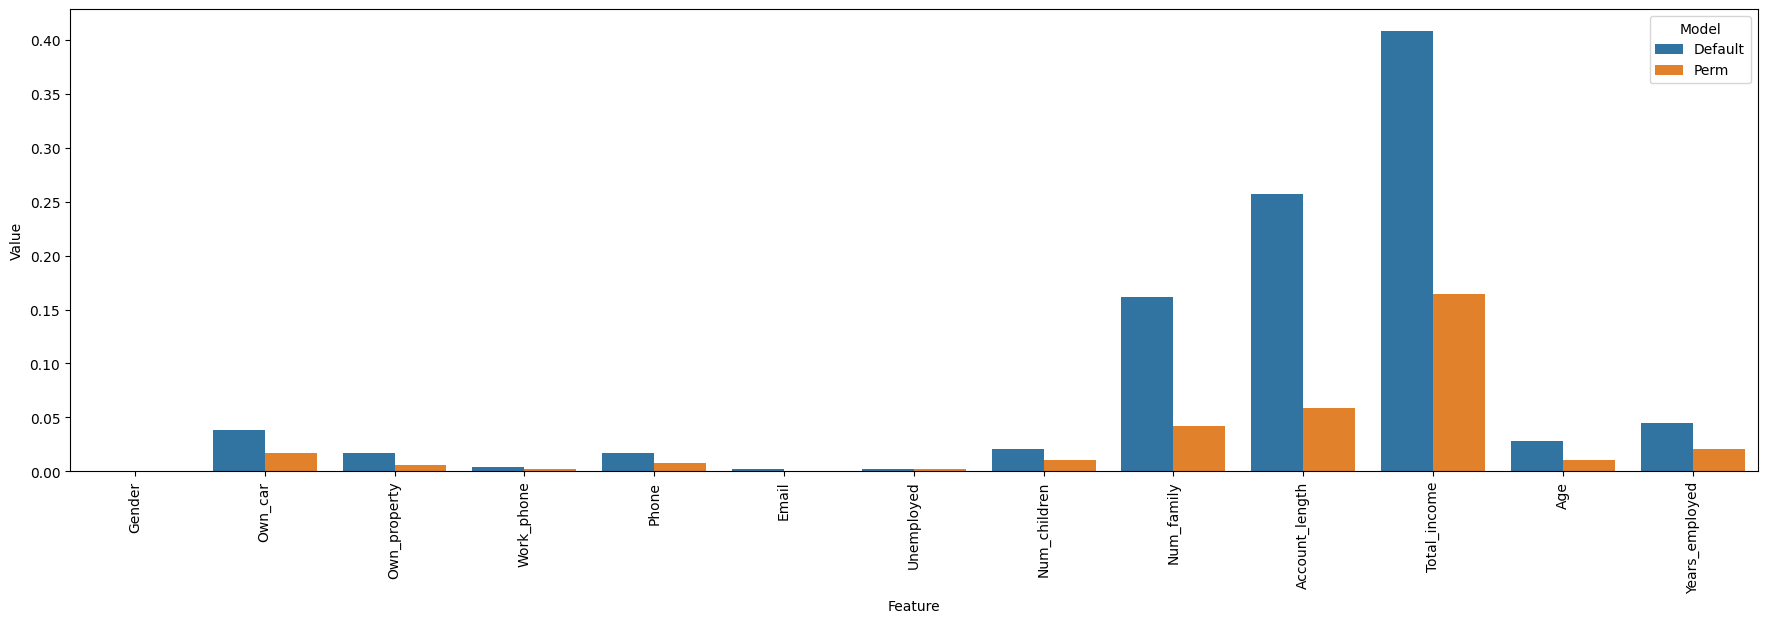

In [ ]:
# RF Classifier
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=random_state)
# clf = GradientBoostingClassifier(n_estimators=100)

gb_classifier.fit(Xtr_smote_scaled, ytr_smote)

features = X.columns

from sklearn.inspection import permutation_importance

# Permutation feature importance
result = permutation_importance(
    gb_classifier, Xtr_smote_scaled, ytr_smote, n_repeats=10, random_state=random_state, n_jobs=2
)

default_feature_importance = pd.DataFrame({'Feature': features, 'Value': gb_classifier.feature_importances_, "Model": ["Default" for x in range(len(gb_classifier.feature_importances_))]})
permutation_feature_importance = pd.DataFrame({'Feature': features, 'Value': result.importances_mean, "Model": ["Perm" for x in range(len(result.importances_mean))]})
combined = pd.concat([default_feature_importance, permutation_feature_importance], axis=0)

fig = plt.figure(figsize=(9,6))
gs = gridspec.GridSpec(1, 1, right=2)
ax1 = fig.add_subplot(gs[0, 0])

g = sns.barplot(combined, x="Feature", y="Value", hue="Model", ax=ax1)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

## Selecting Features

In [ ]:
# Which feature importance do we like better?

default = {}
perm = {}
# Only gonna test grabbing the top 2 > 10 features
features = range(2, 11)
# Test every feature selection <loops> times
loops = 3

for feature_len in features:
    print("\n", feature_len, ":", end="")

    # Get top X features from default / permutation feature importance
    top_d = default_feature_importance.sort_values("Value").tail(feature_len)["Feature"].tolist()
    top_p = permutation_feature_importance.sort_values("Value").tail(feature_len)["Feature"].tolist()

    # Turn those feature names into col indices
    col_indices_d = [X.columns.get_loc(x) for x in top_d]
    col_indices_p = [X.columns.get_loc(x) for x in top_p]

    # ===========================
    # Default Permutation Feature Importance
    # Select top X features
    Xtr_top_smote_scaled = Xtr_smote_scaled[:,col_indices_d]
    Xts_top_scaled = Xts_scaled[:,col_indices_d]

    for loop in range(loops):
        gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=random_state * feature_len + loop)
        gb_classifier.fit(Xtr_top_smote_scaled, ytr_smote)
        print("d", end="")

        # Score the classifier
        if feature_len in default:
            default[feature_len].append(gb_classifier.score(Xts_top_scaled, y_test))
        else:
            default[feature_len] = [gb_classifier.score(Xts_top_scaled, y_test)]

    # ===========================
    # Permutation-based feature importance
    # Select top X features
    Xtr_top_smote_scaled = Xtr_smote_scaled[:,col_indices_p]
    Xts_top_scaled = Xts_scaled[:,col_indices_p]

    for loop in range(loops):
        gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=random_state * feature_len + loop)
        gb_classifier.fit(Xtr_top_smote_scaled, ytr_smote)
        print("p", end="")

        # Score the classifier
        if feature_len in perm:
            perm[feature_len].append(gb_classifier.score(Xts_top_scaled, y_test))
        else:
            perm[feature_len] = [gb_classifier.score(Xts_top_scaled, y_test)]


 2 :dddppp
 3 :dddppp
 4 :dddppp
 5 :dddppp
 6 :dddppp
 7 :dddppp
 8 :dddppp
 9 :dddppp
 10 :dddppp

In [ ]:
import pprint

print("Default features")
for k,v in default.items():
    print(k, ":", sum(v) / len(v))
print("Permuted features")
for k,v in perm.items():
    print(k, ":", sum(v) / len(v))

Default features
2 : 0.7392703862660944
3 : 0.7526824034334764
4 : 0.7424892703862661
5 : 0.7489270386266095
6 : 0.7446351931330472
7 : 0.75
8 : 0.7467811158798283
9 : 0.7451716738197426
10 : 0.7526824034334764
Permuted features
2 : 0.7392703862660944
3 : 0.7526824034334764
4 : 0.7424892703862661
5 : 0.7489270386266095
6 : 0.7446351931330472
7 : 0.75
8 : 0.7467811158798283
9 : 0.7451716738197426
10 : 0.7451716738197426


Default feature importance > top 3 default has the greatest score

## Training the model

In [ ]:
top = default_feature_importance.sort_values("Value").tail(2)["Feature"].tolist()
col_indices = [X_train.columns.get_loc(x) for x in top]

Xtr_top_smote_scaled = Xtr_smote_scaled[:,col_indices]
Xts_top_scaled = Xts_scaled[:,col_indices]

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_gbsmote = GridSearchCV(estimator=GradientBoostingClassifier(random_state=random_state),
                           param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2)

grid_search_gbsmote.fit(Xtr_top_smote_scaled, ytr_smote)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


In [ ]:
# Train the Random Forest classifier with best parameters
best_params_gbsmote = grid_search_rfsmote.best_params_
gb_classifier_tuned_gbsmote = GradientBoostingClassifier(**best_params_gbsmote, random_state=random_state)
gb_classifier_tuned_gbsmote.fit(Xtr_top_smote_scaled, ytr_smote)

# Make predictions using the tuned model
y_pred_tuned = gb_classifier_tuned_gbsmote.predict(Xts_top_scaled)

# Evaluate the tuned model
accuracy_tuned_gbsmote = accuracy_score(y_test, y_pred_tuned)
print(f'Accuracy with Tuned Model: {accuracy_tuned_gbsmote:.2f}')
print('Classification Report with Tuned Model:')
print(classification_report(y_test, y_pred_tuned))
print('Confusion Matrix with Tuned Model:')
print(confusion_matrix(y_test, y_pred_tuned))

# GradientBoostClassifier / SMOTENC <a name='gbcsnc'></a>
```
Accuracy with Tuned Model: 0.80
Classification Report with Tuned Model:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1588
           1       0.14      0.06      0.08       276

    accuracy                           0.80      1864
   macro avg       0.49      0.50      0.49      1864
weighted avg       0.75      0.80      0.77      1864

Confusion Matrix with Tuned Model:
[[1480  108]
 [ 259   17]]
```

## Process

I Realized i only need to do scaling and SMOTE once on the dataset, and then select features independently. I dont need to do SMOTE and Scaling every iteration of feature selection

## One-hot encode categorical columns for SMOTENC

SMOTENC requires differentiation between Nominal & Categorical columns, so here we add all of the nominal cols to the end of the dataframe and one-hot encode the categorical columns

In [ ]:
df = df_cleaned.drop(columns=["ID"])
one_hot1 = pd.get_dummies(df_cleaned["Income_type"], dtype=int)
one_hot2 = pd.get_dummies(df_cleaned["Education_type"], dtype=int)
one_hot3 = pd.get_dummies(df_cleaned["Family_status"], dtype=int)
one_hot4 = pd.get_dummies(df_cleaned["Housing_type"], dtype=int)
one_hot5 = pd.get_dummies(df_cleaned["Occupation_type"], dtype=int)
df = df.drop(columns=["Income_type", "Education_type", "Family_status", "Housing_type", "Occupation_type"],axis = 1)
for i in [one_hot1, one_hot2, one_hot3, one_hot4, one_hot5]:
    df = df.join(i)
df["Num_children"] = df.pop("Num_children")
df["Num_family"] = df.pop("Num_family")
df["Account_length"] = df.pop("Account_length")
df["Total_income"] = df.pop("Total_income")
df["Age"] = df.pop("Age")
df["Years_employed"] = df.pop("Years_employed")

## Train Test Split / Scale / SMOTE

In [ ]:
X = df.drop('Target', axis=1)
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

s = StandardScaler()

Xtr_scaled = s.fit_transform(X_train)
Xts_scaled = s.transform(X_test)

smote = SMOTENC(random_state=random_state, categorical_features=list(range(0, 49)))

Xtr_smote_scaled, ytr_smote = smote.fit_resample(Xtr_scaled, y_train)

## Comparing the effectiveness of SMOTE sampling

Original data length: 9316 == Smote data length: 12998
Original value count for each class: [8087, 1229]
Smote value count for each class: [6499, 6499]


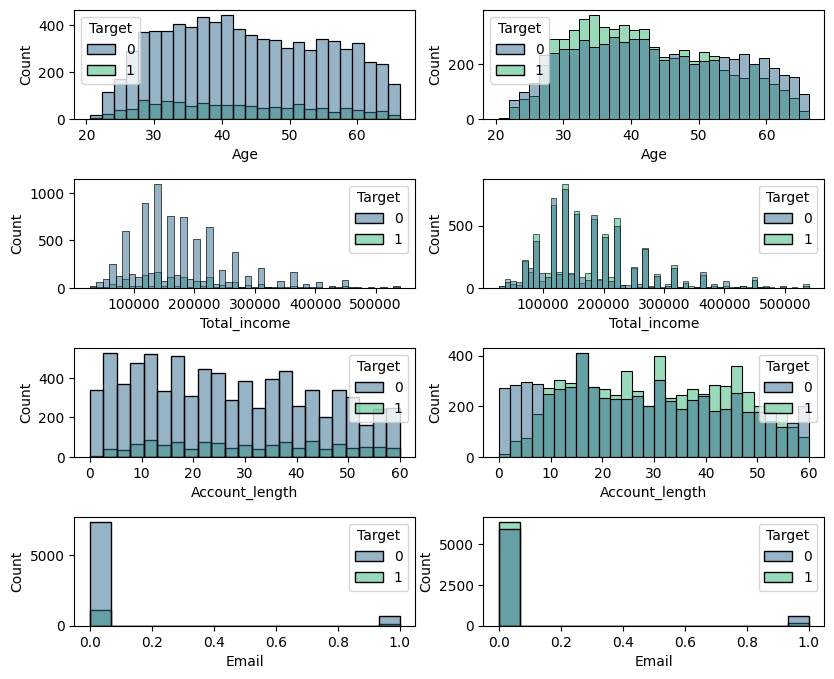

In [ ]:
a, b = smote.fit_resample(X_train, y_train)
df_smote = pd.concat([a, b], axis=1)
print("Original data length:", len( df_cleaned ), "== Smote data length:", len( df_smote ))
print("Original value count for each class:", df_cleaned["Target"].value_counts().tolist())
print("Smote value count for each class:", df_smote["Target"].value_counts().tolist())
fig = plt.figure(figsize=(4,8))
gs = gridspec.GridSpec(4, 2, right=2, hspace=0.55)
for idx,i in enumerate(["Age", "Total_income", "Account_length", "Email"]):
    ax1 = fig.add_subplot(gs[idx, 0])
    ax2 = fig.add_subplot(gs[idx, 1])
    sns.histplot(data=df_smote, x=i, hue='Target', palette='viridis', ax=ax2)
    sns.histplot(data=df_cleaned, x=i, hue='Target', palette='viridis', ax=ax1)

## Identifying feature importance

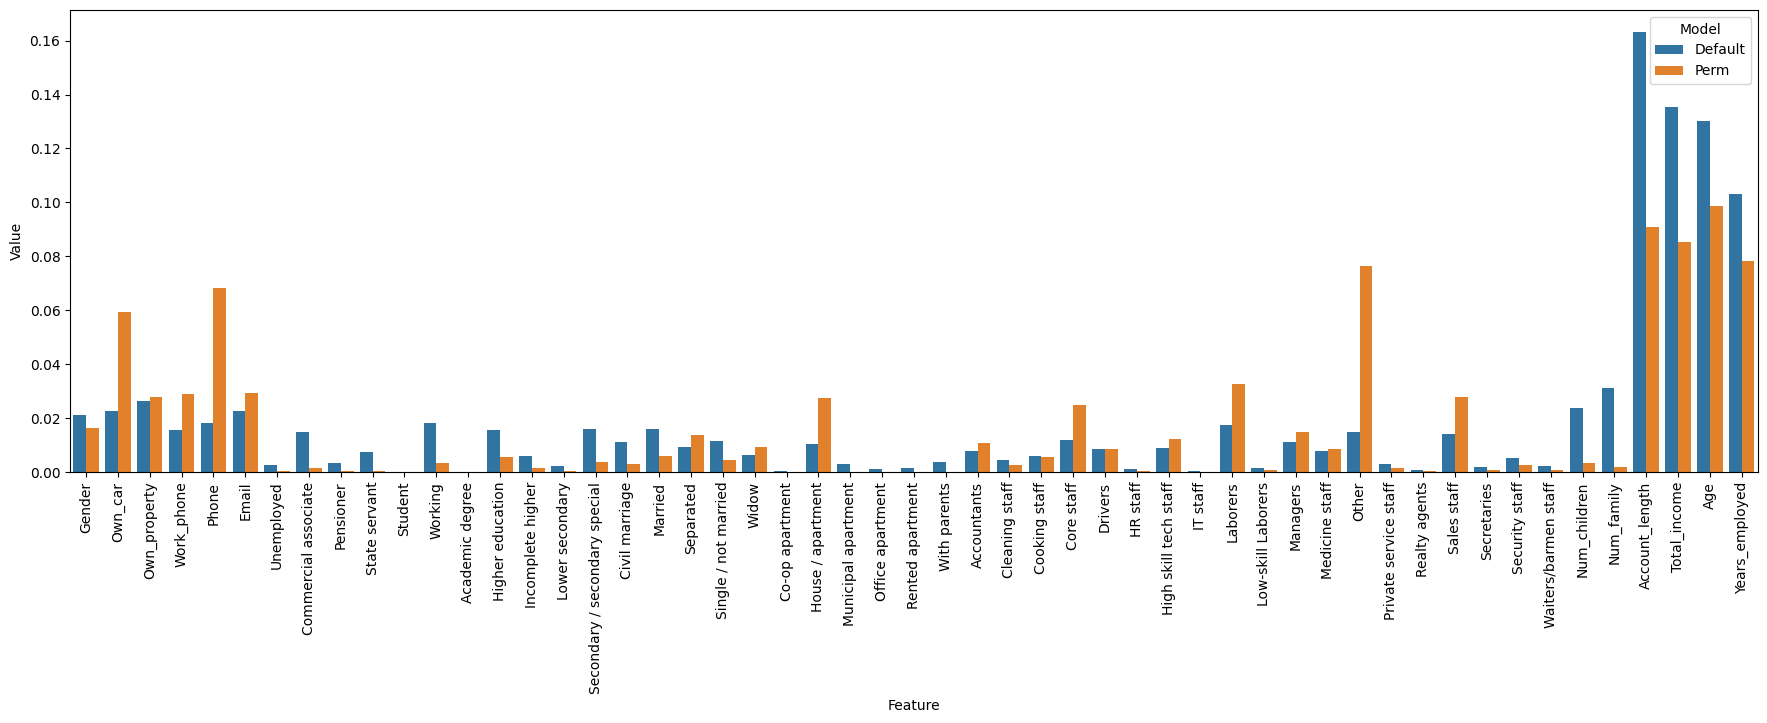

In [ ]:
# RF Classifier
gb_classifier = GradientBoostClassifier(n_estimators=100, random_state=random_state)
gb_classifier.fit(Xtr_smote_scaled, ytr_smote)

features = X.columns

from sklearn.inspection import permutation_importance

# Permutation feature importance
result = permutation_importance(
    gb_classifier, Xtr_smote_scaled, ytr_smote, n_repeats=10, random_state=random_state, n_jobs=2
)

default_feature_importance = pd.DataFrame({'Feature': features, 'Value': gb_classifier.feature_importances_, "Model": ["Default" for x in range(len(gb_classifier.feature_importances_))]})
permutation_feature_importance = pd.DataFrame({'Feature': features, 'Value': result.importances_mean, "Model": ["Perm" for x in range(len(result.importances_mean))]})
combined = pd.concat([default_feature_importance, permutation_feature_importance], axis=0)

fig = plt.figure(figsize=(9,6))
gs = gridspec.GridSpec(1, 1, right=2)
ax1 = fig.add_subplot(gs[0, 0])

g = sns.barplot(combined, x="Feature", y="Value", hue="Model", ax=ax1)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

## Selecting Features

In [ ]:
# Which feature importance do we like better?

default = {}
perm = {}
# Only gonna test grabbing the top 2 > 10 features
features = range(2, 11)
# Test every feature selection <loops> times
loops = 3

for feature_len in features:
    print("\n", feature_len, ":", end="")

    # Get top X features from default / permutation feature importance
    top_d = default_feature_importance.sort_values("Value").tail(feature_len)["Feature"].tolist()
    top_p = permutation_feature_importance.sort_values("Value").tail(feature_len)["Feature"].tolist()

    # Turn those feature names into col indices
    col_indices_d = [X_train.columns.get_loc(x) for x in top_d]
    col_indices_p = [X_train.columns.get_loc(x) for x in top_p]

    # ===========================
    # Default Permutation Feature Importance
    # Select top X features
    Xtr_top_smote_scaled = Xtr_smote_scaled[:,col_indices_d]
    Xts_top_scaled = Xts_scaled[:,col_indices_d]

    for loop in range(loops):
        gb_classifier = GradientBoostClassifier(n_estimators=100, random_state=random_state * feature_len + loop)
        gb_classifier.fit(Xtr_top_smote_scaled, ytr_smote)
        print("d", end="")

        # Score the classifier
        if feature_len in default:
            default[feature_len].append(gb_classifier.score(Xts_top_scaled, y_test))
        else:
            default[feature_len] = [gb_classifier.score(Xts_top_scaled, y_test)]

    # ===========================
    # Permutation-based feature importance
    # Select top X features
    Xtr_top_smote_scaled = Xtr_smote_scaled[:,col_indices_p]
    Xts_top_scaled = Xts_scaled[:,col_indices_p]

    for loop in range(loops):
        gb_classifier = GradientBoostClassifier(n_estimators=100, random_state=random_state * feature_len + loop)
        gb_classifier.fit(Xtr_top_smote_scaled, ytr_smote)
        print("p", end="")

        # Score the classifier
        if feature_len in perm:
            perm[feature_len].append(gb_classifier.score(Xts_top_scaled, y_test))
        else:
            perm[feature_len] = [gb_classifier.score(Xts_top_scaled, y_test)]


 2 :dddppp
 3 :dddppp
 4 :dddppp
 5 :dddppp
 6 :dddppp
 7 :dddppp
 8 :dddppp
 9 :dddppp
 10 :dddppp

In [ ]:
import pprint

print("Default features")
for k,v in default.items():
    print(k, ":", sum(v) / len(v))
print("Permuted features")
for k,v in perm.items():
    print(k, ":", sum(v) / len(v))

Default features
2 : 0.8015021459227468
3 : 0.7328326180257511
4 : 0.7408798283261803
5 : 0.7392703862660944
6 : 0.738197424892704
7 : 0.7408798283261803
8 : 0.7387339055793992
9 : 0.7424892703862661
10 : 0.7451716738197426
Permuted features
2 : 0.6550429184549357
3 : 0.7312231759656652
4 : 0.7451716738197426
5 : 0.7446351931330472
6 : 0.7333690987124464
7 : 0.73068669527897
8 : 0.7317596566523606
9 : 0.7521459227467812
10 : 0.7349785407725321


Default feature importance > top 2 default has the greatest score

## Training the model

In [ ]:
top = default_feature_importance.sort_values("Value").tail(2)["Feature"].tolist()
col_indices = [X_train.columns.get_loc(x) for x in top]

Xtr_top_smote_scaled = Xtr_smote_scaled[:,col_indices]
Xts_top_scaled = Xts_scaled[:,col_indices]

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_gbsmotenc = GridSearchCV(estimator=GradientBoostClassifier(random_state=random_state),
                           param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2)

grid_search_gbsmotenc.fit(Xtr_top_smote_scaled, ytr_smote)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [ ]:
# Train the Random Forest classifier with best parameters
best_params_gbsmotenc = grid_search_gbsmotenc.best_params_
gb_classifier_tuned_gbsmotenc = RandomForestClassifier(**best_params_rfsmotenc, random_state=random_state)
gb_classifier_tuned_gbsmotenc.fit(Xtr_top_smote_scaled, ytr_smote)

# Make predictions using the tuned model
y_pred_tuned = gb_classifier_tuned_gbsmotenc.predict(Xts_top_scaled)

# Evaluate the tuned model
accuracy_tuned_gbsmotenc = accuracy_score(y_test, y_pred_tuned)
print(f'Accuracy with Tuned Model: {accuracy_tuned_gbsmotenc:.2f}')
print('Classification Report with Tuned Model:')
print(classification_report(y_test, y_pred_tuned))
print('Confusion Matrix with Tuned Model:')
print(confusion_matrix(y_test, y_pred_tuned))

Accuracy with Tuned Model: 0.80
Classification Report with Tuned Model:
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1588
           1       0.14      0.06      0.08       276

    accuracy                           0.80      1864
   macro avg       0.49      0.50      0.49      1864
weighted avg       0.75      0.80      0.77      1864

Confusion Matrix with Tuned Model:
[[1480  108]
 [ 259   17]]


# GradientBoostClassifier <a name='gbc'></a>
```

```

## Train Test Split / Scale / ROS

In [ ]:
df = df_cleaned.drop(columns=["ID"])
df = df.select_dtypes(include=['int64', 'float64'])
X = df.drop('Target', axis=1)
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

s = StandardScaler()

Xtr_scaled = s.fit_transform(X_train)
Xts_scaled = s.transform(X_test)

## Identifying feature importance

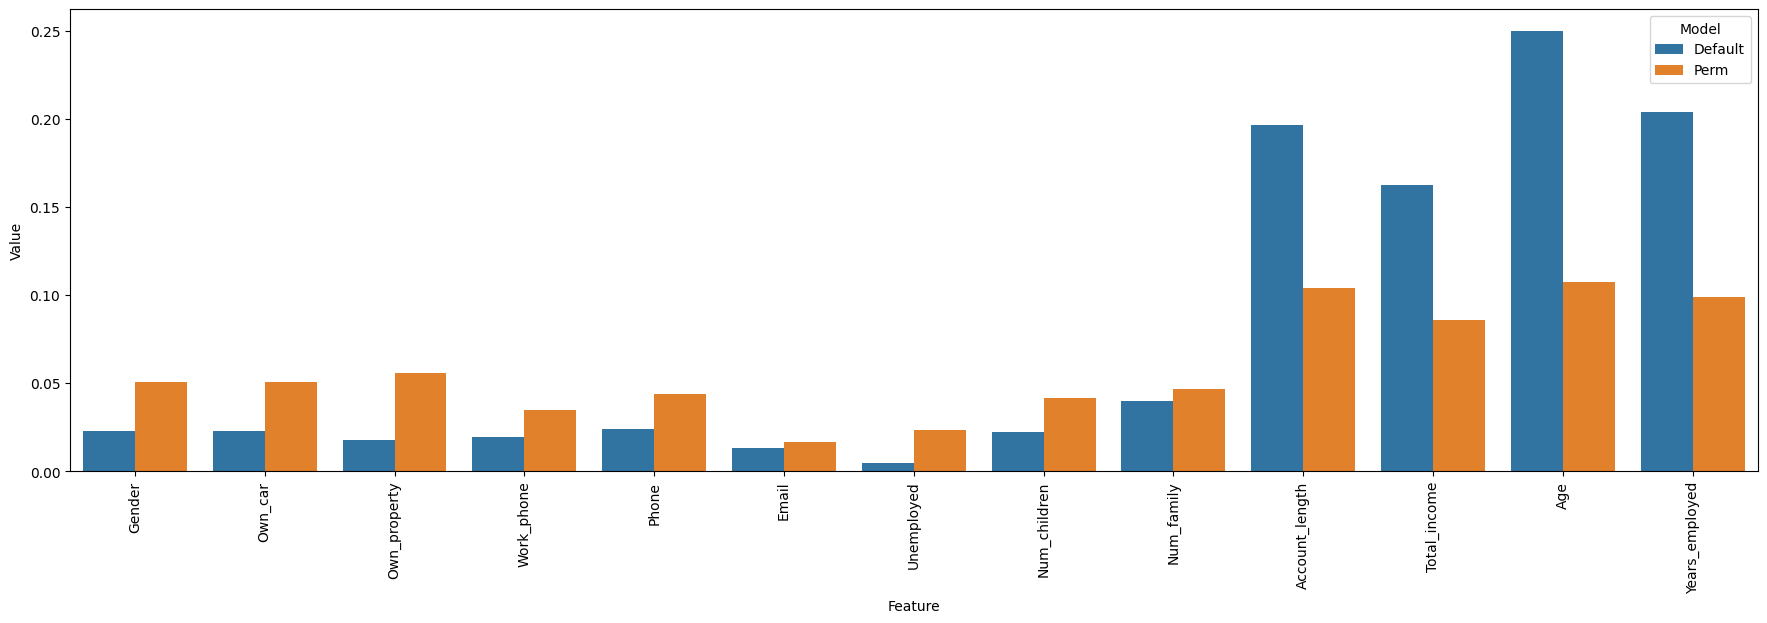

In [ ]:
# RF Classifier
gb_classifier = GradientBoostClassifier(n_estimators=100, random_state=random_state)
gb_classifier.fit(Xtr_scaled, y_train)

features = X.columns

from sklearn.inspection import permutation_importance

# Permutation feature importance
result = permutation_importance(
    gb_classifier, Xtr_scaled, y_train, n_repeats=10, random_state=random_state, n_jobs=2
)

default_feature_importance = pd.DataFrame({'Feature': features, 'Value': gb_classifier.feature_importances_, "Model": ["Default" for x in range(len(gb_classifier.feature_importances_))]})
permutation_feature_importance = pd.DataFrame({'Feature': features, 'Value': result.importances_mean, "Model": ["Perm" for x in range(len(result.importances_mean))]})
combined = pd.concat([default_feature_importance, permutation_feature_importance], axis=0)

fig = plt.figure(figsize=(9,6))
gs = gridspec.GridSpec(1, 1, right=2)
ax1 = fig.add_subplot(gs[0, 0])

g = sns.barplot(combined, x="Feature", y="Value", hue="Model", ax=ax1)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

## Selecting Features

In [ ]:
# Which feature importance do we like better?

default = {}
perm = {}
# Only gonna test grabbing the top 2 > 10 features
features = range(2, 11)
# Test every feature selection <loops> times
loops = 3

for feature_len in features:
    print("\n", feature_len, ":", end="")

    # Get top X features from default / permutation feature importance
    top_d = default_feature_importance.sort_values("Value").tail(feature_len)["Feature"].tolist()
    top_p = permutation_feature_importance.sort_values("Value").tail(feature_len)["Feature"].tolist()

    # Turn those feature names into col indices
    col_indices_d = [X.columns.get_loc(x) for x in top_d]
    col_indices_p = [X.columns.get_loc(x) for x in top_p]

    # ===========================
    # Default Permutation Feature Importance
    # Select top X features
    Xtr_top_scaled = Xtr_scaled[:,col_indices_d]
    Xts_top_scaled = Xts_scaled[:,col_indices_d]

    for loop in range(loops):
        gb_classifier = GradientBoostClassifier(n_estimators=100, random_state=random_state * feature_len + loop)
        gb_classifier.fit(Xtr_top_scaled, y_train)
        print("d", end="")

        # Score the classifier
        if feature_len in default:
            default[feature_len].append(gb_classifier.score(Xts_top_scaled, y_test))
        else:
            default[feature_len] = [gb_classifier.score(Xts_top_scaled, y_test)]

    # ===========================
    # Permutation-based feature importance
    # Select top X features
    Xtr_top_scaled = Xtr_scaled[:,col_indices_p]
    Xts_top_scaled = Xts_scaled[:,col_indices_p]

    for loop in range(loops):
        gb_classifier = GradientBoostClassifier(n_estimators=100, random_state=random_state * feature_len + loop)
        gb_classifier.fit(Xtr_top_scaled, y_train)
        print("p", end="")

        # Score the classifier
        if feature_len in perm:
            perm[feature_len].append(gb_classifier.score(Xts_top_scaled, y_test))
        else:
            perm[feature_len] = [gb_classifier.score(Xts_top_scaled, y_test)]


 2 :dddppp
 3 :dddppp
 4 :dddppp
 5 :dddppp
 6 :dddppp
 7 :dddppp
 8 :dddppp
 9 :dddppp
 10 :dddppp

In [ ]:
import pprint

print("Default features")
for k,v in default.items():
    print(k, ":", sum(v) / len(v))
print("Permuted features")
for k,v in perm.items():
    print(k, ":", sum(v) / len(v))

Default features
2 : 0.8356580829756796
3 : 0.8410228898426323
4 : 0.8483547925608012
5 : 0.8512160228898425
6 : 0.8510371959942775
7 : 0.8513948497854078
8 : 0.8522889842632332
9 : 0.851931330472103
10 : 0.851931330472103
Permuted features
2 : 0.7945278969957082
3 : 0.8412017167381974
4 : 0.8472818311874106
5 : 0.8490701001430615
6 : 0.8485336194563663
7 : 0.8510371959942775
8 : 0.8522889842632332
9 : 0.851931330472103
10 : 0.8522889842632332


Default feature importance > top 8 default has the greatest score

## Training the model

In [ ]:
top = default_feature_importance.sort_values("Value").tail(8)["Feature"].tolist()
col_indices = [X_train.columns.get_loc(x) for x in top]

Xtr_top_scaled = Xtr_scaled[:,col_indices]
Xts_top_scaled = Xts_scaled[:,col_indices]

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=GradientBoostClassifier(random_state=random_state),
                           param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2)

grid_search.fit(Xtr_top_scaled, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [ ]:
# Train the Random Forest classifier with best parameters
best_params = grid_search.best_params_
gb_classifier_tuned = GradientBoostClassifier(**best_params, random_state=random_state)
gb_classifier_tuned.fit(Xtr_top_scaled, y_train)

# Make predictions using the tuned model
y_pred_tuned = gb_classifier_tuned.predict(Xts_top_scaled)

# Evaluate the tuned model
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f'Accuracy with Tuned Model: {accuracy_tuned:.2f}')
print('Classification Report with Tuned Model:')
print(classification_report(y_test, y_pred_tuned))
print('Confusion Matrix with Tuned Model:')
print(confusion_matrix(y_test, y_pred_tuned))

Accuracy with Tuned Model: 0.85
Classification Report with Tuned Model:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      1588
           1       0.50      0.00      0.01       276

    accuracy                           0.85      1864
   macro avg       0.68      0.50      0.46      1864
weighted avg       0.80      0.85      0.78      1864

Confusion Matrix with Tuned Model:
[[1587    1]
 [ 275    1]]


# GradientBoostClassifier / RandomOverSampler ('auto') <a name='gbcrosa'></a>
```

```

## Train Test Split / Scale / ROS

In [ ]:
df = df_cleaned.drop(columns=["ID"])
df = df.select_dtypes(include=['int64', 'float64'])
X = df.drop('Target', axis=1)
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

s = StandardScaler()

Xtr_scaled = s.fit_transform(X_train)
Xts_scaled = s.transform(X_test)

ros = RandomOverSampler(sampling_strategy='auto')

Xtr_ros_scaled, ytr_ros = ros.fit_resample(Xtr_scaled, y_train)

## Comparing the effectiveness of ROS sampling

Original data length: 9316 == ros data length: 12998
Original value count for each class: [8087, 1229]
ros value count for each class: [6499, 6499]


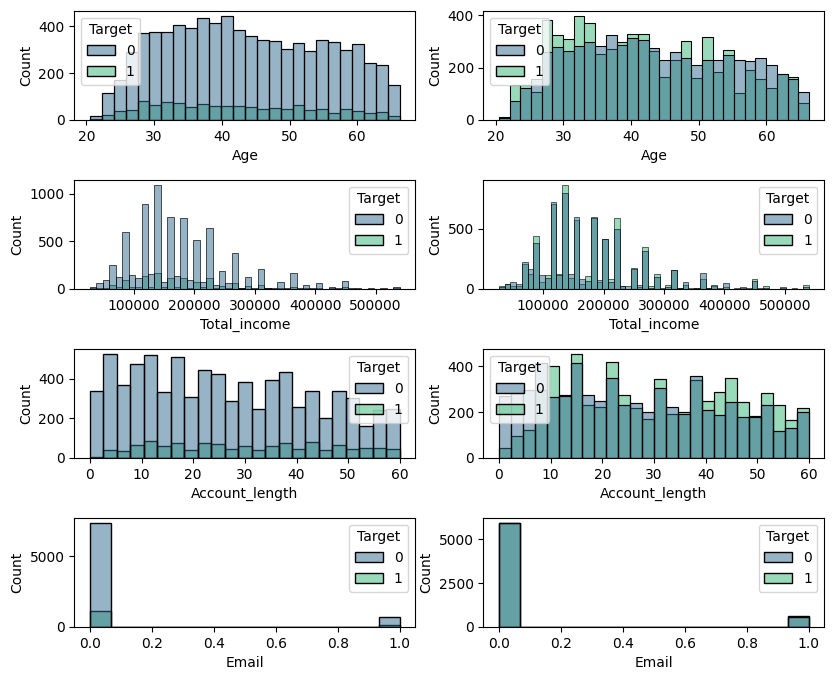

In [ ]:
a, b = ros.fit_resample(X_train, y_train)
df_ros = pd.concat([a, b], axis=1)
print("Original data length:", len( df_cleaned ), "== ros data length:", len( df_ros ))
print("Original value count for each class:", df_cleaned["Target"].value_counts().tolist())
print("ros value count for each class:", df_ros["Target"].value_counts().tolist())
fig = plt.figure(figsize=(4,8))
gs = gridspec.GridSpec(4, 2, right=2, hspace=0.55)
for idx,i in enumerate(["Age", "Total_income", "Account_length", "Email"]):
    ax1 = fig.add_subplot(gs[idx, 0])
    ax2 = fig.add_subplot(gs[idx, 1])
    sns.histplot(data=df_ros, x=i, hue='Target', palette='viridis', ax=ax2)
    sns.histplot(data=df_cleaned, x=i, hue='Target', palette='viridis', ax=ax1)

## Identifying feature importance

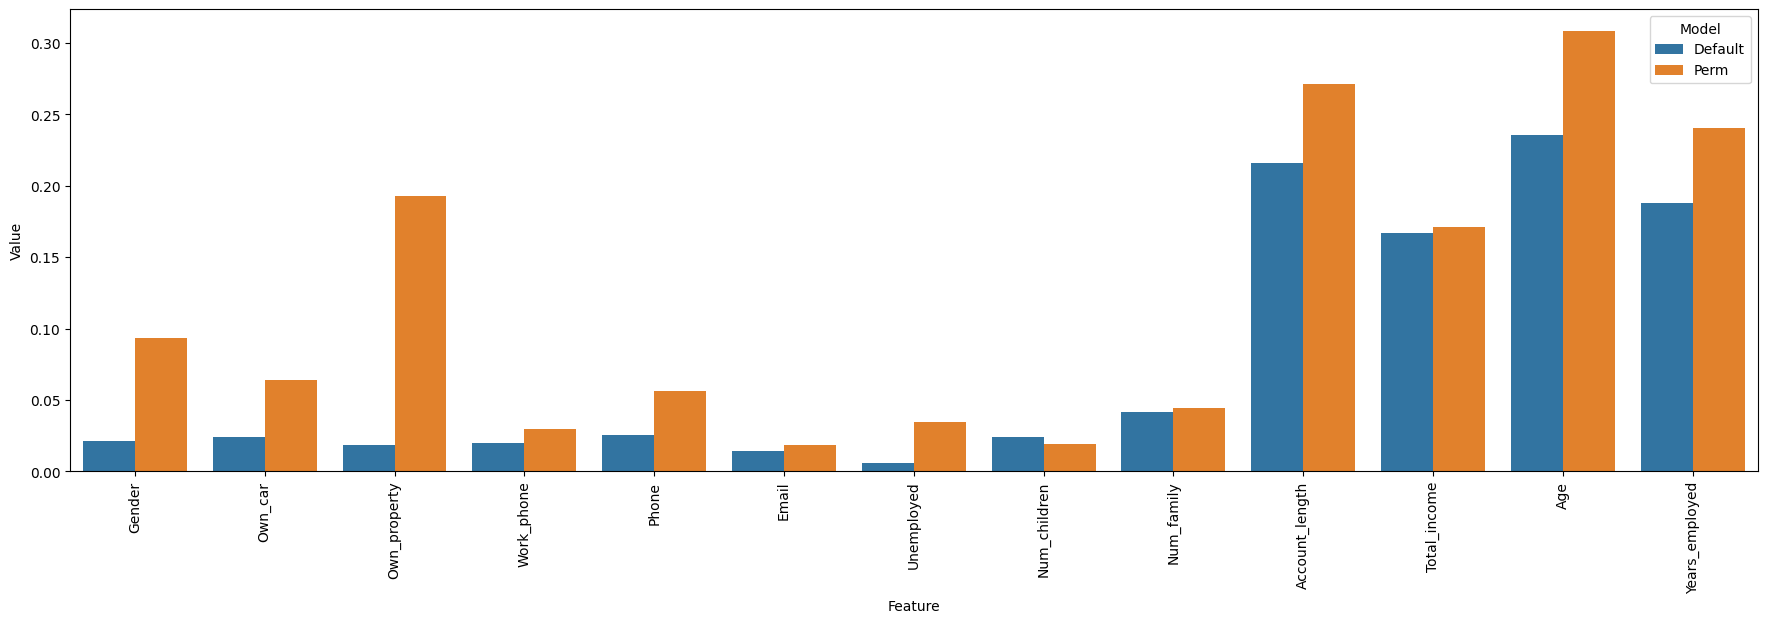

In [ ]:
# RF Classifier
gb_classifier = GradientBoostClassifier(n_estimators=100, random_state=random_state)
gb_classifier.fit(Xtr_ros_scaled, ytr_ros)

features = X.columns

from sklearn.inspection import permutation_importance

# Permutation feature importance
result = permutation_importance(
    gb_classifier, Xtr_ros_scaled, ytr_ros, n_repeats=10, random_state=random_state, n_jobs=2
)

default_feature_importance = pd.DataFrame({'Feature': features, 'Value': gb_classifier.feature_importances_, "Model": ["Default" for x in range(len(gb_classifier.feature_importances_))]})
permutation_feature_importance = pd.DataFrame({'Feature': features, 'Value': result.importances_mean, "Model": ["Perm" for x in range(len(result.importances_mean))]})
combined = pd.concat([default_feature_importance, permutation_feature_importance], axis=0)

fig = plt.figure(figsize=(9,6))
gs = gridspec.GridSpec(1, 1, right=2)
ax1 = fig.add_subplot(gs[0, 0])

g = sns.barplot(combined, x="Feature", y="Value", hue="Model", ax=ax1)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

## Selecting Features

In [ ]:
# Which feature importance do we like better?

default = {}
perm = {}
# Only gonna test grabbing the top 2 > 10 features
features = range(2, 11)
# Test every feature selection <loops> times
loops = 3

for feature_len in features:
    print("\n", feature_len, ":", end="")

    # Get top X features from default / permutation feature importance
    top_d = default_feature_importance.sort_values("Value").tail(feature_len)["Feature"].tolist()
    top_p = permutation_feature_importance.sort_values("Value").tail(feature_len)["Feature"].tolist()

    # Turn those feature names into col indices
    col_indices_d = [X.columns.get_loc(x) for x in top_d]
    col_indices_p = [X.columns.get_loc(x) for x in top_p]

    # ===========================
    # Default Permutation Feature Importance
    # Select top X features
    Xtr_top_ros_scaled = Xtr_ros_scaled[:,col_indices_d]
    Xts_top_scaled = Xts_scaled[:,col_indices_d]

    for loop in range(loops):
        gb_classifier = GradientBoostClassifier(n_estimators=100, random_state=random_state * feature_len + loop)
        gb_classifier.fit(Xtr_top_ros_scaled, ytr_ros)
        print("d", end="")

        # Score the classifier
        if feature_len in default:
            default[feature_len].append(gb_classifier.score(Xts_top_scaled, y_test))
        else:
            default[feature_len] = [gb_classifier.score(Xts_top_scaled, y_test)]

    # ===========================
    # Permutation-based feature importance
    # Select top X features
    Xtr_top_ros_scaled = Xtr_ros_scaled[:,col_indices_p]
    Xts_top_scaled = Xts_scaled[:,col_indices_p]

    for loop in range(loops):
        gb_classifier = GradientBoostClassifier(n_estimators=100, random_state=random_state * feature_len + loop)
        gb_classifier.fit(Xtr_top_ros_scaled, ytr_ros)
        print("p", end="")

        # Score the classifier
        if feature_len in perm:
            perm[feature_len].append(gb_classifier.score(Xts_top_scaled, y_test))
        else:
            perm[feature_len] = [gb_classifier.score(Xts_top_scaled, y_test)]


 2 :dddppp
 3 :dddppp
 4 :dddppp
 5 :dddppp
 6 :dddppp
 7 :dddppp
 8 :dddppp
 9 :dddppp
 10 :dddppp

In [ ]:
import pprint

print("Default features")
for k,v in default.items():
    print(k, ":", sum(v) / len(v))
print("Permuted features")
for k,v in perm.items():
    print(k, ":", sum(v) / len(v))

Default features
2 : 0.7592989985693848
3 : 0.8156294706723891
4 : 0.8267167381974249
5 : 0.8324391988555079
6 : 0.8408440629470673
7 : 0.8426323319027181
8 : 0.8420958512160229
9 : 0.844241773962804
10 : 0.8435264663805436
Permuted features
2 : 0.7592989985693848
3 : 0.8156294706723891
4 : 0.8174177396280401
5 : 0.8311874105865522
6 : 0.8335121602288984
7 : 0.8349427753934191
8 : 0.8417381974248928
9 : 0.8410228898426323
10 : 0.8438841201716739


Default feature importance > top 9 default has the greatest score

## Training the model

In [ ]:
top = default_feature_importance.sort_values("Value").tail(9)["Feature"].tolist()
col_indices = [X_train.columns.get_loc(x) for x in top]

Xtr_top_ros_scaled = Xtr_ros_scaled[:,col_indices]
Xts_top_scaled = Xts_scaled[:,col_indices]

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search_gbros = GridSearchCV(estimator=GradientBoostClassifier(random_state=random_state),
                           param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2)

grid_search_gbros.fit(Xtr_top_ros_scaled, ytr_ros)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [ ]:
# Train the Random Forest classifier with best parameters
best_params_gbros = grid_search_gbros.best_params_
gb_classifier_tuned_gbros = GradientBoostClassifier(**best_params_rfros, random_state=random_state)
gb_classifier_tuned_gbros.fit(Xtr_top_ros_scaled, ytr_ros)

# Make predictions using the tuned model
y_pred_tuned = gb_classifier_tuned_gbros.predict(Xts_top_scaled)

# Evaluate the tuned model
accuracy_tuned_gbros = accuracy_score(y_test, y_pred_tuned)
print(f'Accuracy with Tuned Model: {accuracy_tuned_rfros:.2f}')
print('Classification Report with Tuned Model:')
print(classification_report(y_test, y_pred_tuned))
print('Confusion Matrix with Tuned Model:')
print(confusion_matrix(y_test, y_pred_tuned))

Accuracy with Tuned Model: 0.84
Classification Report with Tuned Model:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      1588
           1       0.26      0.03      0.06       276

    accuracy                           0.84      1864
   macro avg       0.56      0.51      0.49      1864
weighted avg       0.77      0.84      0.79      1864

Confusion Matrix with Tuned Model:
[[1563   25]
 [ 267    9]]
